-> outliner(box plot) ----> use 

-> not normal distribute(QQ plot) ----> Logarithmic transformation (machine learning models, including Neural Networks, Support Vector Machines, Tree based methods and PCA do not make any assumption over the distribution of the independent variables. However, in many occasions the model performance may benefit from a "Gaussian-like" distribution.)

-> feature is not linear to target of future log return ----> will create new feature

-> not scale() ----> Min-Max scaling (Gradient descent converges much faster with feature scaling done. Gradient descent is a common optimization algorithm used in neural networks etc.) BUT (tree-based models don’t calculate distances between data points. This makes them inherently scale-invariant.)

Linear Regression Feature Scaling: Not strictly required but beneficial for gradient descent convergence. Handling Missing Values: Necessary, as it cannot handle missing data directly. Handling Outliers: Important, since outliers can heavily influence the regression line. Feature Transformation: Useful if relationships are non-linear (e.g., applying a log transform). Feature Construction: Helpful for capturing interactions but not mandatory. Conclusion: Most steps are important, but scaling and construction are not absolute requirements. Decision Trees Feature Scaling: Not needed, as splits are based on order, not magnitude. Handling Missing Values: Some implementations can handle them, reducing the necessity. Handling Outliers: Robust to outliers due to split-based decisions. Feature Transformation: Rarely required unless specific preprocessing is desired. Feature Construction: Useful but not essential, as trees can capture interactions. Conclusion: Does not require all steps, especially scaling. Neural Networks Feature Scaling: Critical for gradient-based optimization to ensure stable convergence. Handling Missing Values: Required, as neural networks cannot process missing data directly. Handling Outliers: Important, as outliers can skew weight updates. Feature Transformation: Often needed depending on activation functions or data distribution. Feature Construction: Beneficial for better input representation but not always mandatory. Conclusion: Requires most steps, but construction is optional. Support Vector Machines (SVM) Feature Scaling: Essential, as SVMs rely on distances between points. Handling Missing Values: Necessary, as missing data disrupts distance calculations. Handling Outliers: Critical, since outliers can affect the decision boundary. Feature Transformation: Often inherent via kernel tricks (e.g., RBF), but preprocessing transformations may also be needed. Feature Construction: Useful for improving feature relevance but not strictly required. Conclusion: Close, but construction is not an absolute necessity. k-Nearest Neighbors (kNN) Feature Scaling: Mandatory, as distance metrics (e.g., Euclidean) are sensitive to feature magnitudes—unscaled features skew neighbor selection. Handling Missing Values: Essential, as kNN cannot compute distances with missing data without imputation. Handling Outliers: Necessary, since outliers can dominate distance calculations and mislead neighbor identification. Feature Transformation: Often required to ensure features align with distance metric assumptions (e.g., normalizing distributions). Feature Construction: Important to create meaningful features that enhance similarity measures, especially in complex datasets. Conclusion: Requires all steps for optimal performance, as each directly impacts distance computations.


Click to add a cell.

# BaseLine - Linear Regression Model

In [136]:
from feature_construction_oop import StockFeaturePipeline
from plot_line import *
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from plot_distribution import *
import seaborn as sns
from scipy.stats import probplot
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [137]:
pipeline = StockFeaturePipeline('/Users/kevinleungch421/Documents/GitHub/Database/DataBase/stock_price.sqlite')
data = pipeline.run_pipeline('2017-01-01', '2021-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2017-01-31 to 2020-12-31
Freq: M
Columns: 189 entries, open to Future_Log_Returns
dtypes: float64(185), int64(2), object(1), period[M](1)
memory usage: 71.2+ KB
None


# Missing Data Assumption
Linear regression cannot process missing data directly. If your dataset contains missing values (e.g., NaN entries), the algorithm will either fail or produce incorrect results.

In [138]:
# check
print("Missing Values before Cleaning:")
print(data.isnull().sum().sort_values(ascending=False))

Missing Values before Cleaning:
Future_Log_Returns    1
^VXN_lag1             0
^TNX_lag63            0
DX-Y.NYB_lag1         0
DX-Y.NYB_lag10        0
                     ..
Typical_Price         0
VWAP_20               0
Unemployment_error    0
CPI_error             0
^VIX_lag1             0
Length: 189, dtype: int64


In [139]:
# function
def handle_missing_values(df):
    df = df.dropna(subset=['Future_Log_Returns']) # Drop rows where 'Future_Log_Returns' is NaN
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns # Fill NaN in other numerical columns with their means
    numerical_cols = numerical_cols.drop('Future_Log_Returns', errors='ignore')
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].mean())
    return df

In [140]:
# execute
clean_df = handle_missing_values(data)

In [141]:
# Verify 
print("Remaining null counts:")
print(clean_df.isnull().sum().sort_values(ascending=False))

Remaining null counts:
open                  0
^VXN_lag1             0
^TNX_lag63            0
DX-Y.NYB_lag1         0
DX-Y.NYB_lag10        0
                     ..
Typical_Price         0
VWAP_20               0
Unemployment_error    0
CPI_error             0
Future_Log_Returns    0
Length: 189, dtype: int64


# Outliner Assumption
Outliers are data points that deviate significantly from the rest of the dataset. In linear regression, the model minimizes the sum of squared errors, so outliers with large errors can disproportionately pull the regression line toward them. This can distort the model, making it less representative of the general trend.

A z-score is a way to measure how far a value is from the average (mean) of a column in a dataset. It tells you this distance in terms of "standard deviations," which is a measure of how spread out the data is.

z_score = (value - mean) / standard_deviation

By default, the threshold is 3. If the absolute z-score of a value is greater than 3 (i.e., more than 3 standard deviations from the mean), it’s flagged as an outlier.

et Bounds: For each column, it calculates:
Lower bound = mean - threshold * standard deviation
Upper bound = mean + threshold * standard deviation By default, threshold is 3, so bounds are 3 standard deviations from the mean.

In [142]:
# function
def z_score_mark_outliers(df, threshold=3, handle_outliers=False, plot_cols=None):
    df = df.copy()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if not numerical_cols.size:
        print("No numerical columns found in the DataFrame.")
        df['is_outlier'] = False
        return df
    
    is_outlier = pd.Series(False, index=df.index)
    total_outliers = 0
    outlier_columns = []
    
    for col in numerical_cols:
        mean = df[col].mean()
        std = df[col].std()
        if std == 0:
            print(f"Skipping {col}: standard deviation is zero.")
            continue
        z_scores = np.abs((df[col] - mean) / std)
        col_outliers = z_scores > threshold
        if col_outliers.any():
            outlier_columns.append(col)
        is_outlier = is_outlier | col_outliers
        col_outliers_count = col_outliers.sum()
        total_outliers += col_outliers_count
        if col_outliers_count != 0:
            print(f"Column {col}: {col_outliers_count} outliers detected.")
    
    if plot_cols is None:
        plot_cols = outlier_columns[:4]  # Default to up to 4 columns with outliers
    
    if handle_outliers:
        # Store original data for plotting
        df_original = df.copy()
        
        for col in numerical_cols:
            mean = df[col].mean()
            std = df[col].std()
            if std == 0:
                continue
            lower_bound = mean - threshold * std
            upper_bound = mean + threshold * std
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        
        # Plot box plots before and after
        if plot_cols:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            axes = axes.flatten()
            for i, col in enumerate(plot_cols[:4]):
                ax = axes[i]
                # Before
                ax.boxplot(df_original[col], positions=[1], widths=0.4, patch_artist=True, boxprops=dict(facecolor='lightblue'))
                # After
                ax.boxplot(df[col], positions=[2], widths=0.4, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
                ax.set_xticks([1, 2])
                ax.set_xticklabels(['Before', 'After'])
                ax.set_title(col)
            plt.tight_layout()
            plt.show()
    else:
        df['is_outlier'] = is_outlier
        # Plot box plots before (original data)
        if plot_cols:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            axes = axes.flatten()
            for i, col in enumerate(plot_cols[:4]):
                ax = axes[i]
                ax.boxplot(df[col], patch_artist=True, boxprops=dict(facecolor='lightblue'))
                ax.set_title(col)
            plt.tight_layout()
            plt.show()
    
    prob = 100 * 2 * norm.sf(threshold)
    print(f"\nz-score threshold of {threshold} corresponds to a probability of {prob:.2f}%")
    print(f"Total outliers detected across all columns: {total_outliers}")
    if not handle_outliers:
        print(f"Rows marked as outliers: {is_outlier.sum()}")
    else:
        print("Outliers have been handled by capping values at the z-score threshold.")
    
    # Drop 'is_outlier' only if it exists
    if 'is_outlier' in df.columns:
        df.drop('is_outlier', axis=1, inplace=True)
    
    return df

Column volume: 1 outliers detected.
Column Unemployment_Actual: 2 outliers detected.
Column Unemployment_Predicted: 2 outliers detected.
Column Nonfarm_Payrolls_Actual: 1 outliers detected.
Column Nonfarm_Payrolls_Predicted: 1 outliers detected.
Column Retail_Sales_Actual: 2 outliers detected.
Column Retail_Sales_Predicted: 3 outliers detected.
Column Industrial_Production_Actual: 1 outliers detected.
Column Industrial_Production_Predicted: 1 outliers detected.
Column Personal_Income_Actual: 1 outliers detected.
Column Personal_Income_Predicted: 2 outliers detected.
Column ^VIX: 1 outliers detected.
Column BTC-USD: 1 outliers detected.
Column ^VXN: 1 outliers detected.
Column ^N225: 1 outliers detected.
Column ^GDAXI: 1 outliers detected.
Column ^GSPTSE: 1 outliers detected.
Column MACD: 1 outliers detected.
Column MACD_signal: 1 outliers detected.
Column MACD_histogram: 1 outliers detected.
Column ROC_10: 1 outliers detected.
Column BB_Width: 1 outliers detected.
Column ATR_14: 1 outl

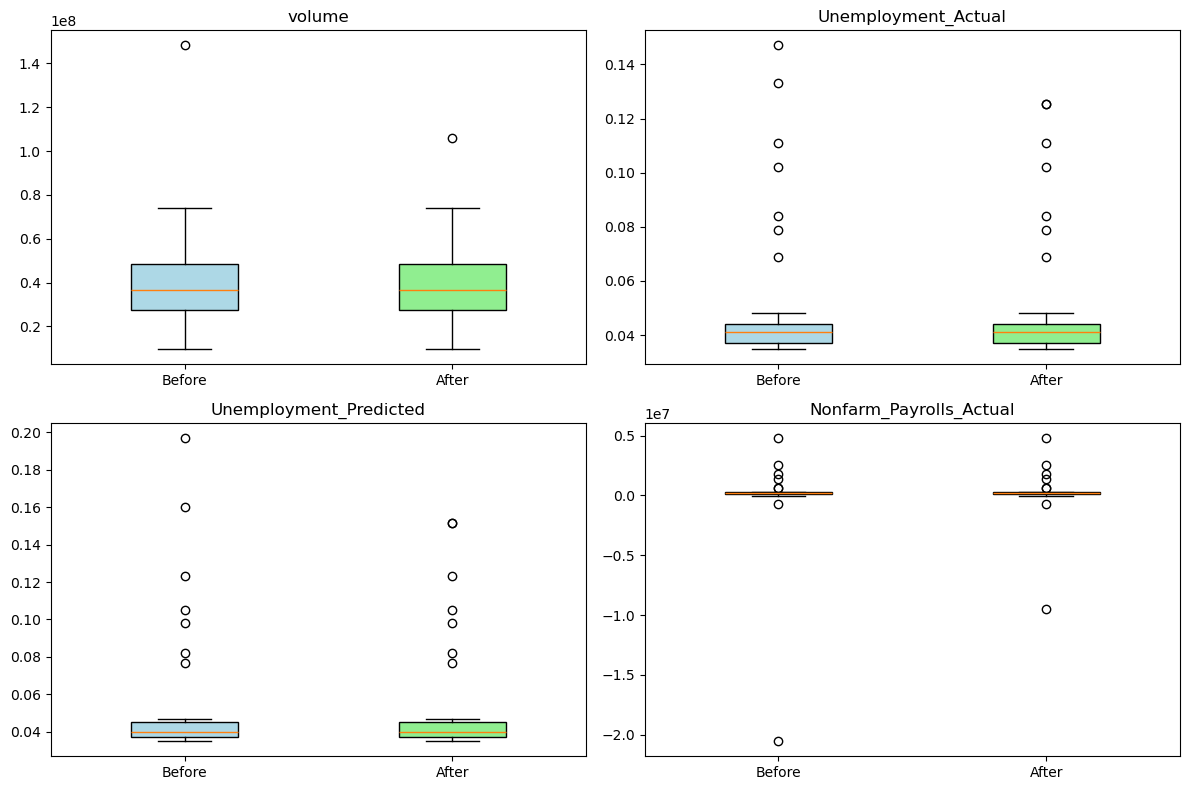


z-score threshold of 3 corresponds to a probability of 0.27%
Total outliers detected across all columns: 65
Outliers have been handled by capping values at the z-score threshold.


In [143]:
# Apply
outliner_df = z_score_mark_outliers(clean_df, threshold=3, handle_outliers=True, plot_cols=None)

In [144]:
# Check
print("\nShape of DataFrame:", outliner_df.shape)


Shape of DataFrame: (47, 189)


# Log Transformation

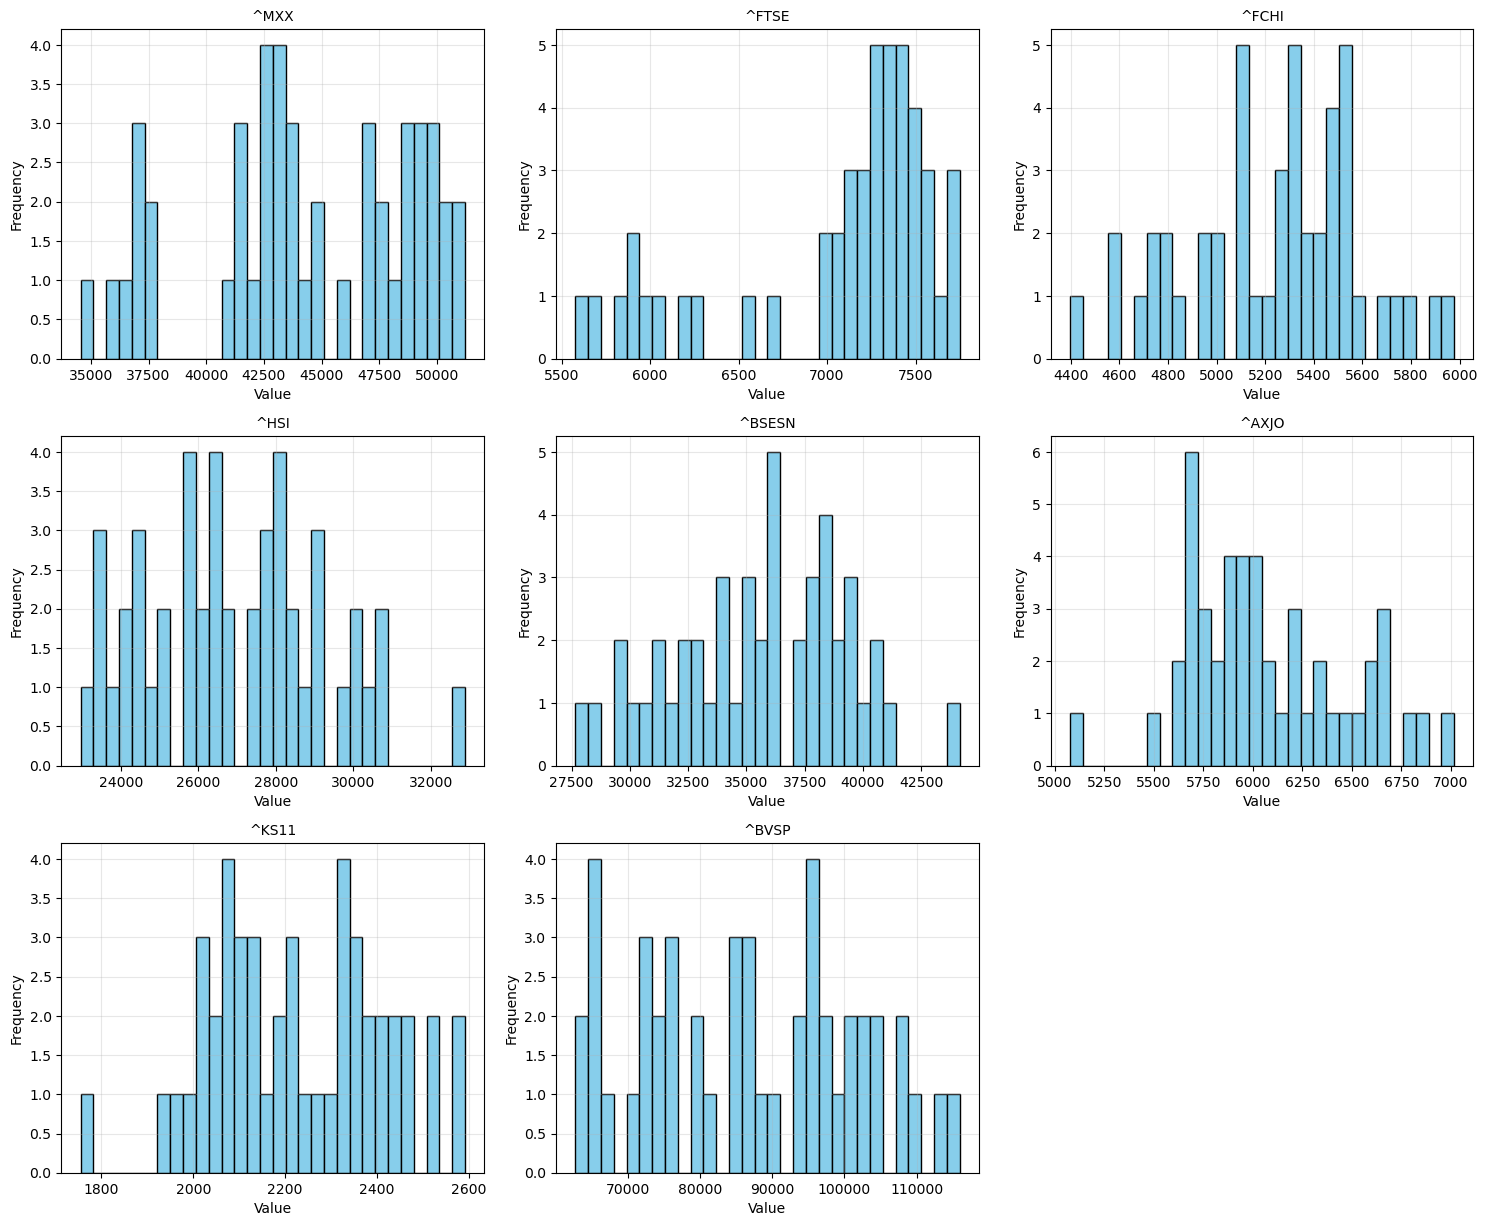

Distribution plots saved as 'competitors_distribution_figX.png' for 8 columns.


In [145]:
# problem
competitors_indicators = ['^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP']
plot_competitors_distribution(outliner_df, competitors_indicators)

In [146]:
def log_transform_df(df):
    df = df.copy()  # Avoid modifying the input DataFrame
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if not numerical_cols.size:
        print("No numerical columns found in the DataFrame.")
        return df
    
    for col in numerical_cols:
        min_value = df[col].min()
        constant = abs(min_value) + 1 if min_value <= 0 else 1
        df[col] = np.log(df[col] + constant)
        
    return df

In [147]:
transformed_df = log_transform_df(outliner_df)

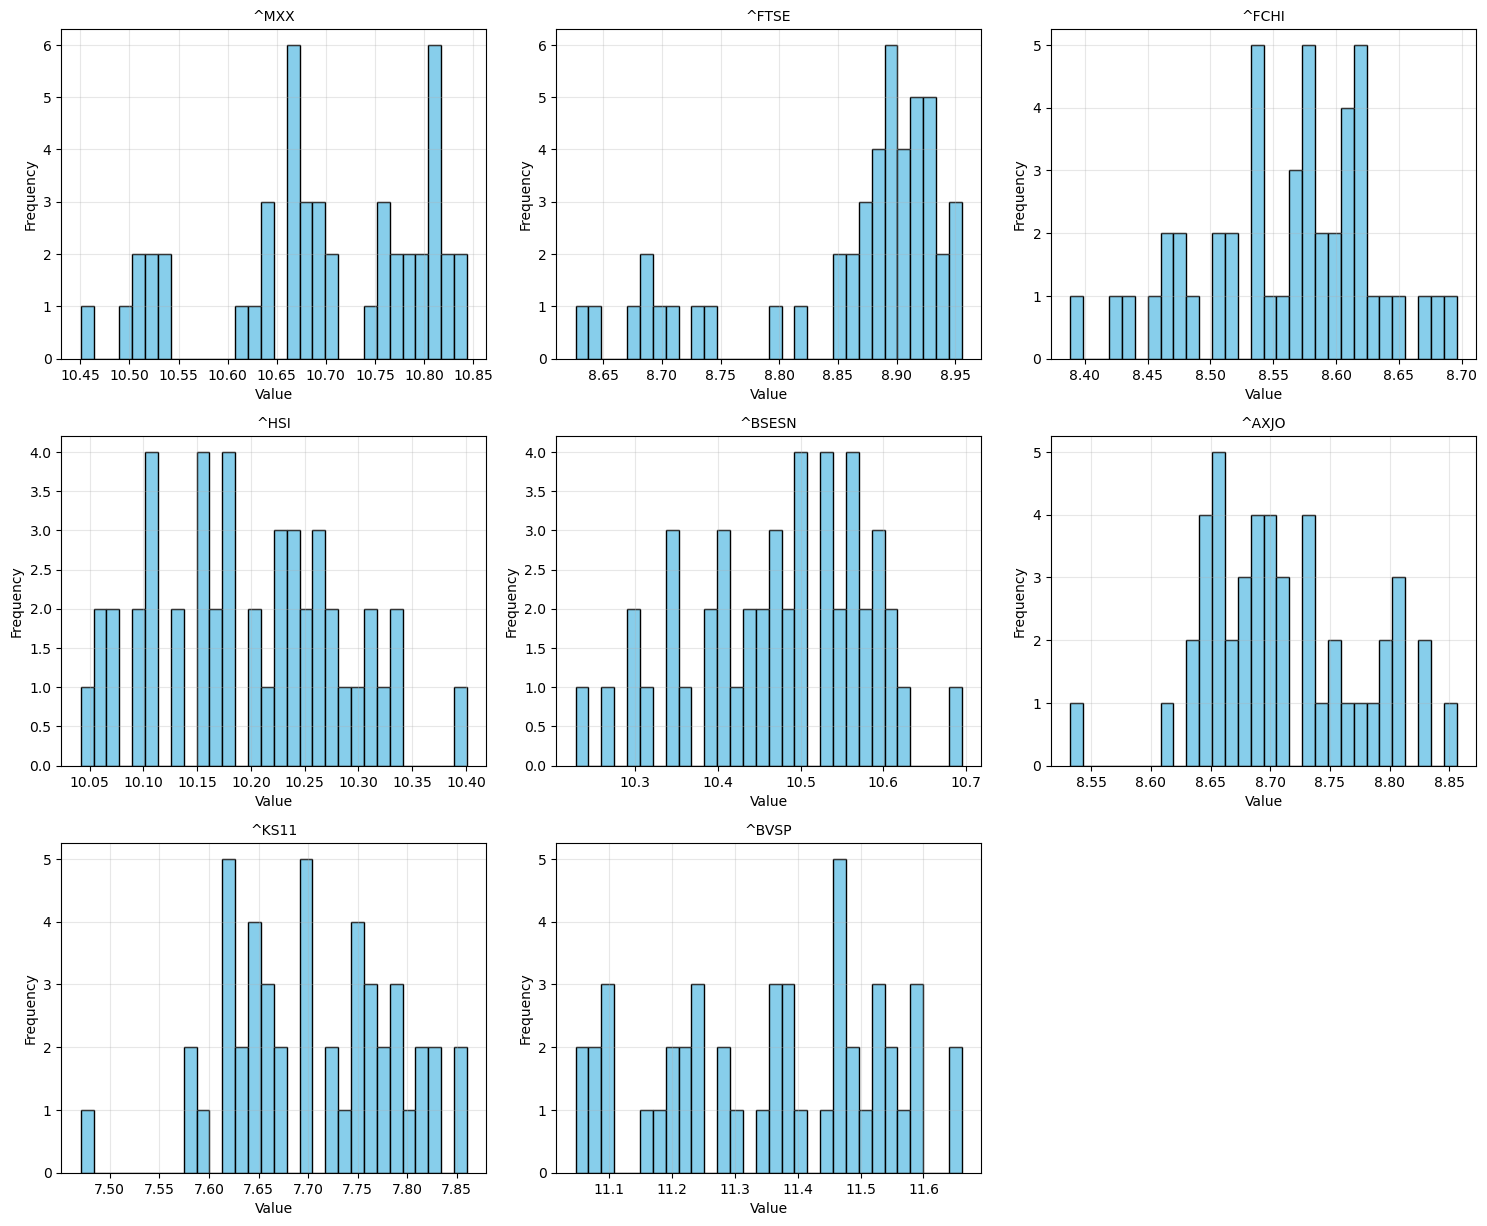

Distribution plots saved as 'competitors_distribution_figX.png' for 8 columns.


In [148]:
# verify
plot_competitors_distribution(transformed_df, competitors_indicators)

# Scaling Assumption

In [149]:
import pandas as pd
import numpy as np

def min_max_scaler_all_numerical(df, feature_range=(0, 1)):

    df = df.copy()  
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if not numerical_cols.size:
        print("No numerical columns found in the DataFrame.")
        return df
    
    for col in numerical_cols:
        # Skip columns with NaN or constant values
        if df[col].isna().all() or df[col].nunique() <= 1:
            print(f"Skipping {col}: contains only NaN or constant values.")
            continue
        
        # Get min and max
        col_min = df[col].min()
        col_max = df[col].max()
        
        # Avoid division by zero if max equals min
        if col_max == col_min:
            print(f"Skipping {col}: max equals min (constant column).")
            continue
        
        # Apply Min-Max Scaling
        df[col] = (df[col] - col_min) / (col_max - col_min) * (feature_range[1] - feature_range[0]) + feature_range[0]
    
    return df

In [150]:
# Apply Min-Max Scaling to all numerical columns
scaled_df = min_max_scaler_all_numerical(transformed_df, feature_range=(0, 1))

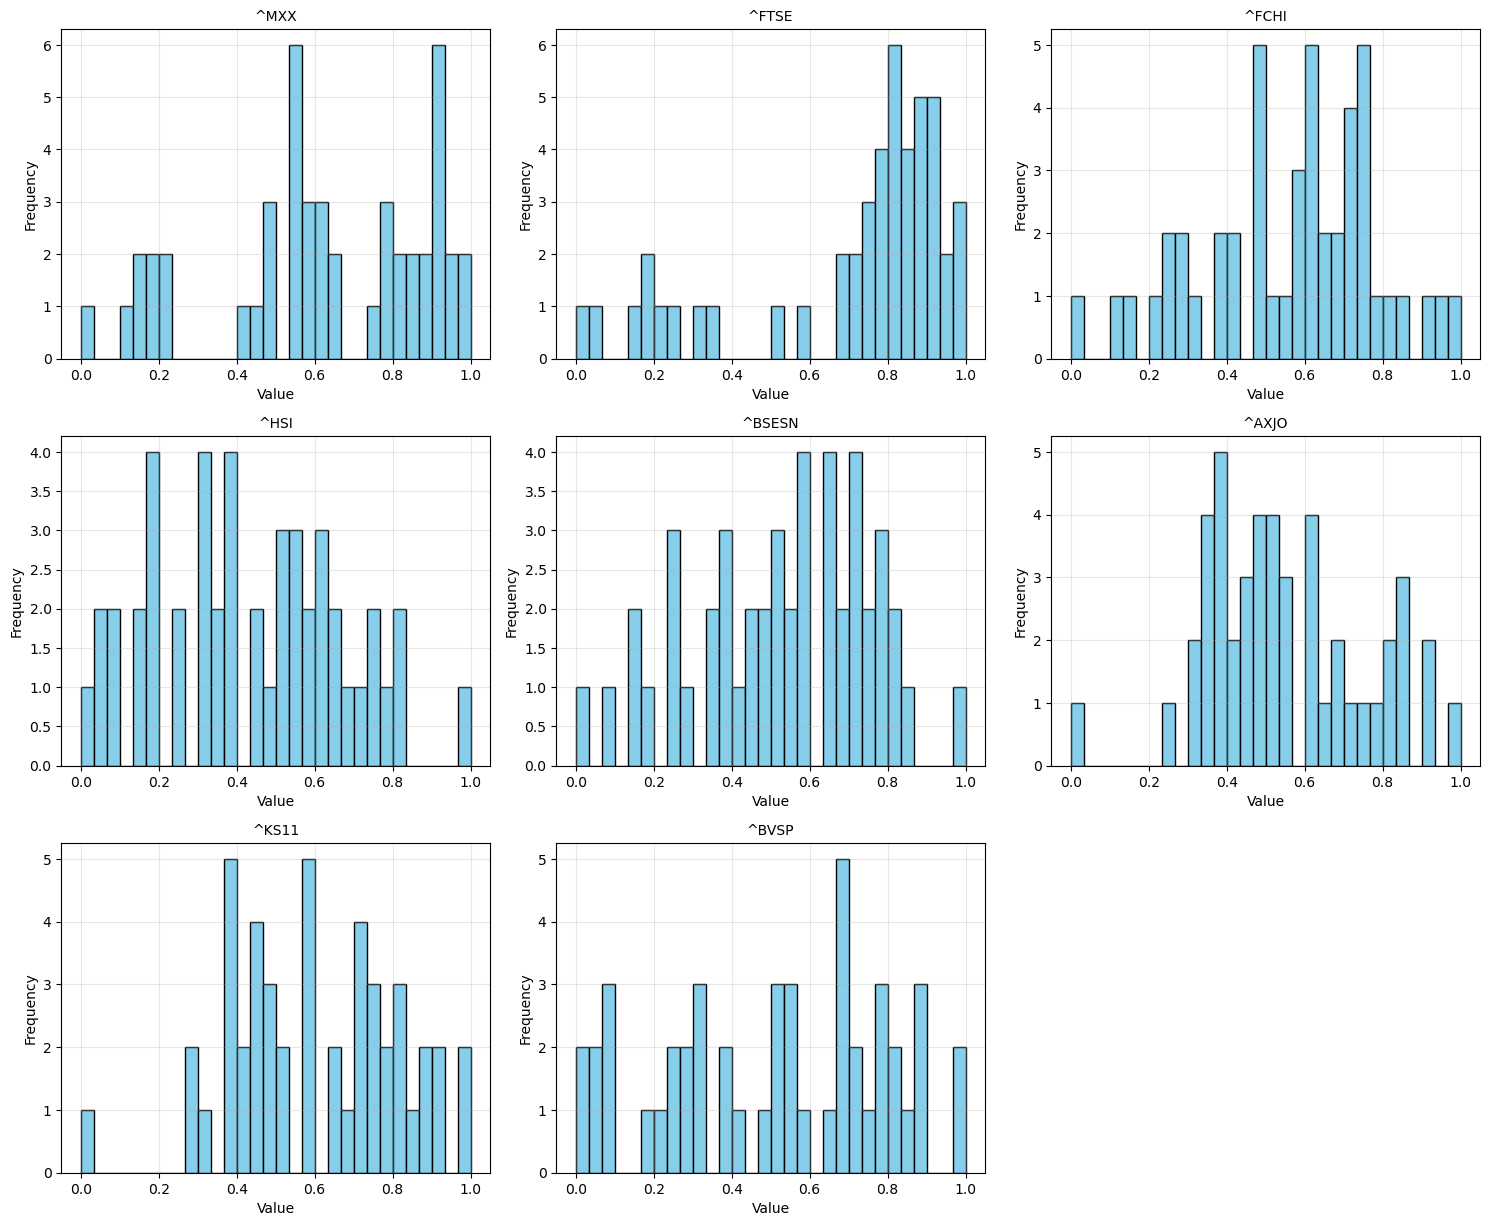

Distribution plots saved as 'competitors_distribution_figX.png' for 8 columns.


In [151]:
# Check
plot_competitors_distribution(scaled_df, competitors_indicators)

# Correlation Check

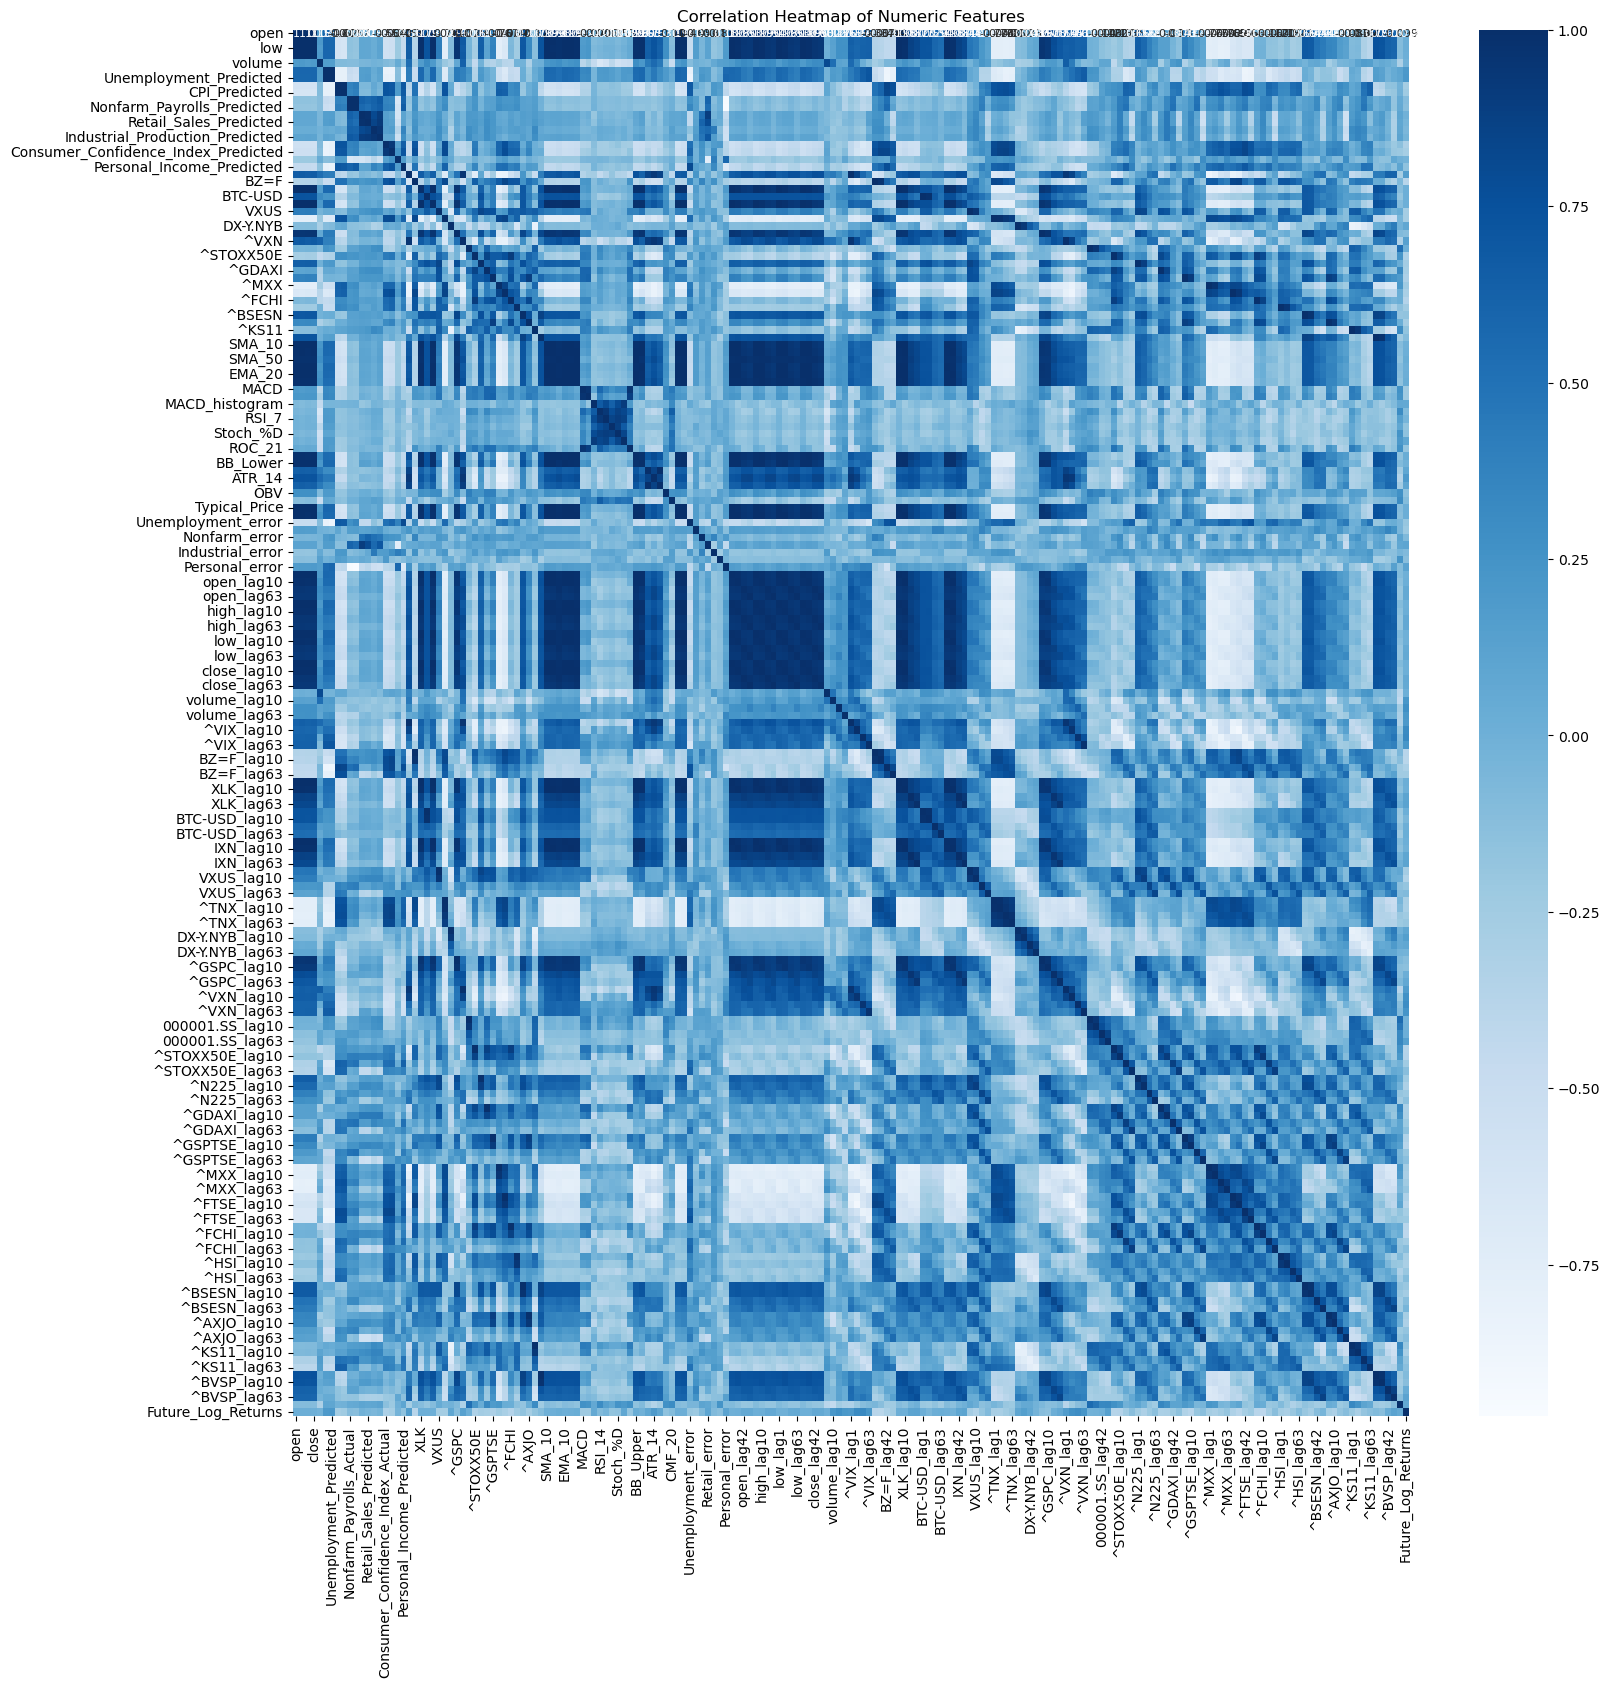

In [152]:
numeric_df = scaled_df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
plt.figure(figsize=(18, 18))
cor1 = numeric_df.corr()
sns.heatmap(cor1, annot=True, cmap="Blues", annot_kws={"size": 8})
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Noraml Distributed Assumption

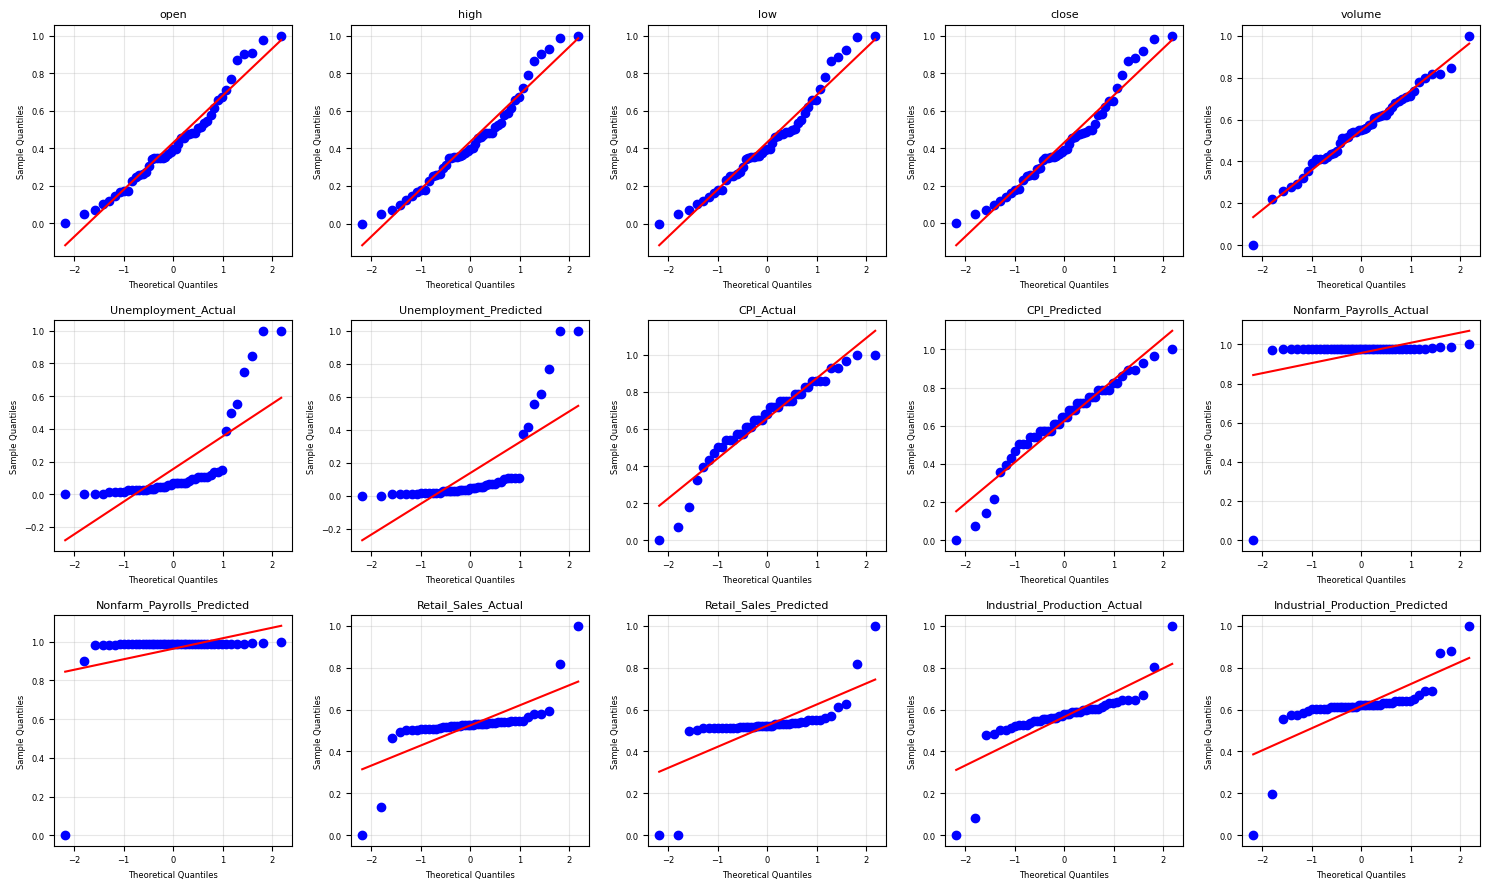

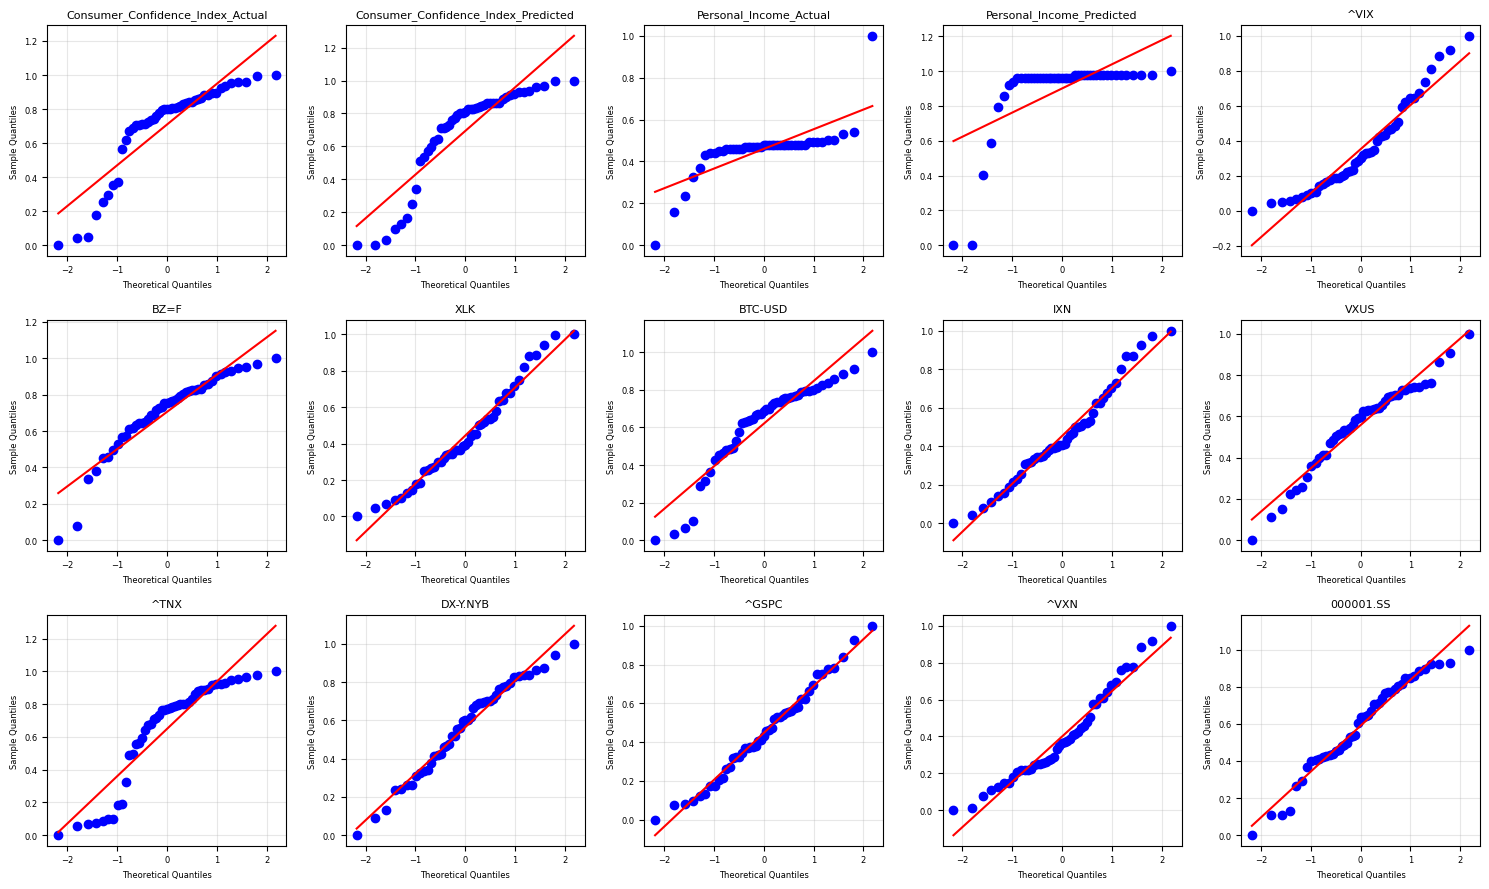

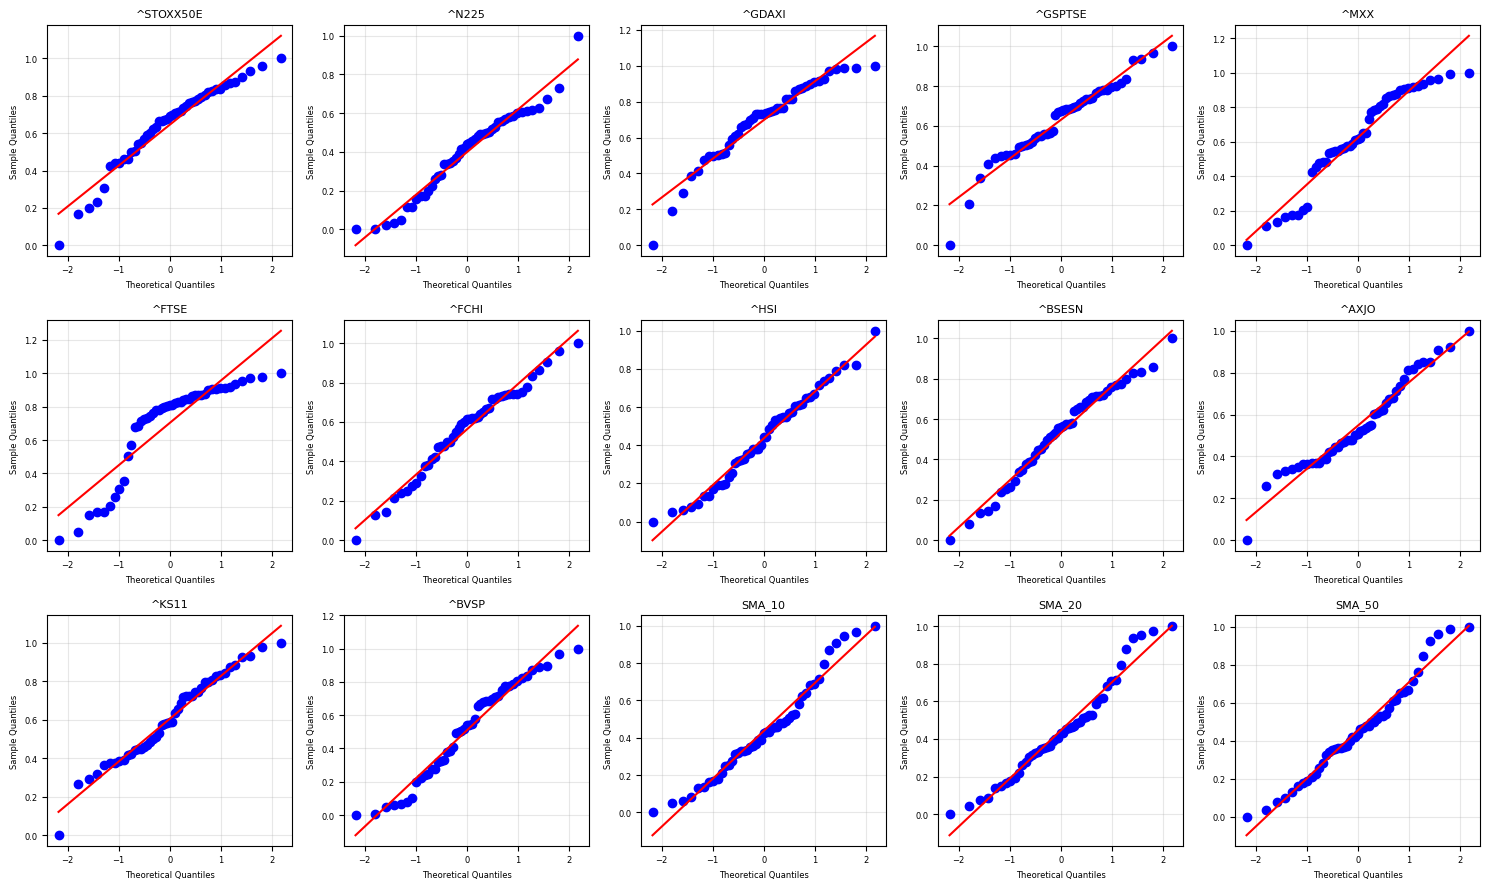

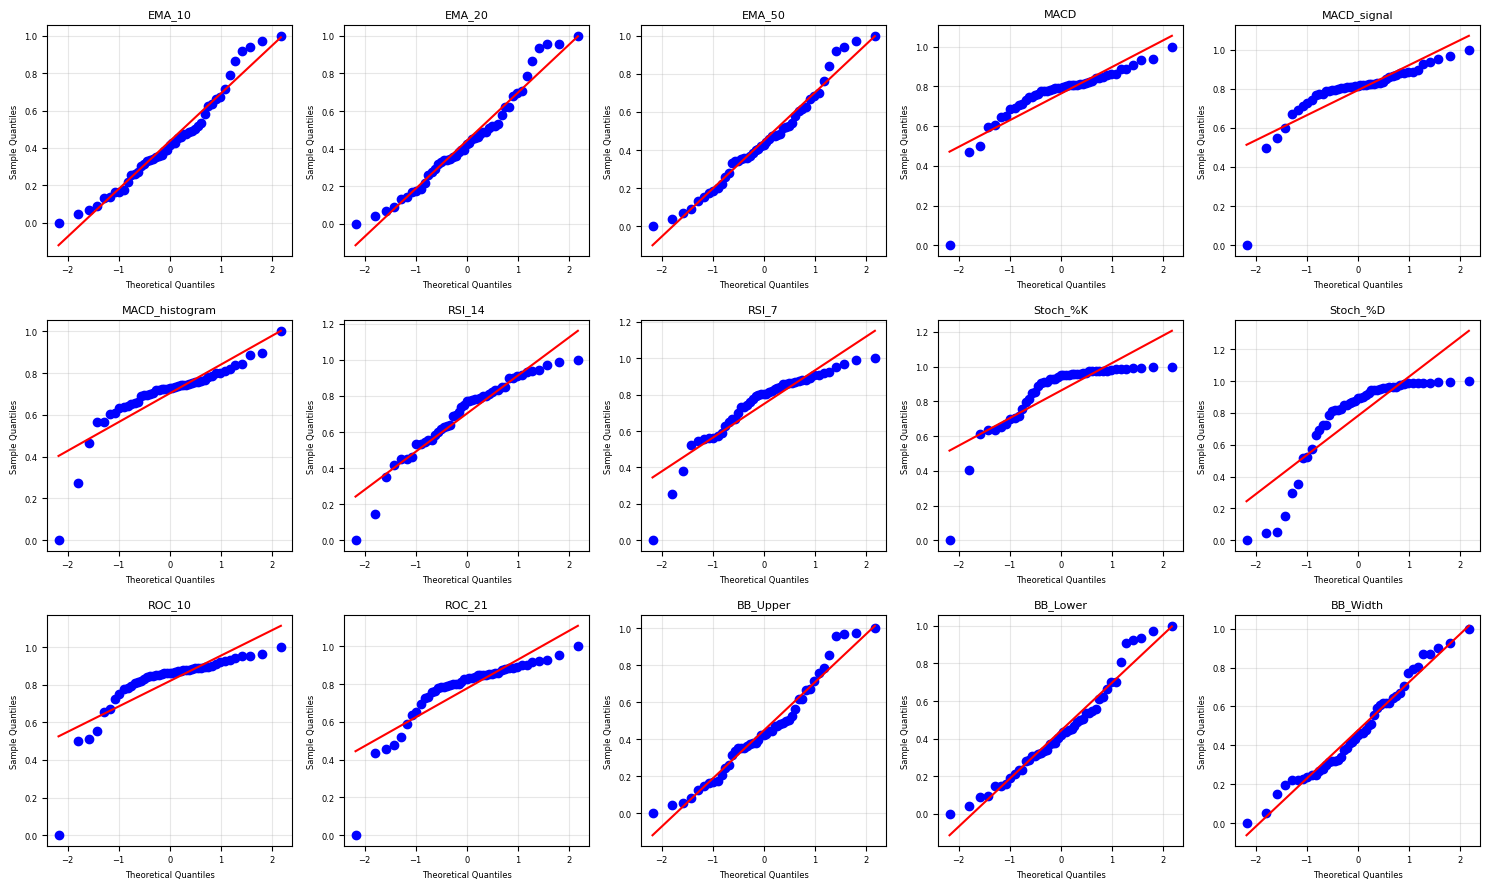

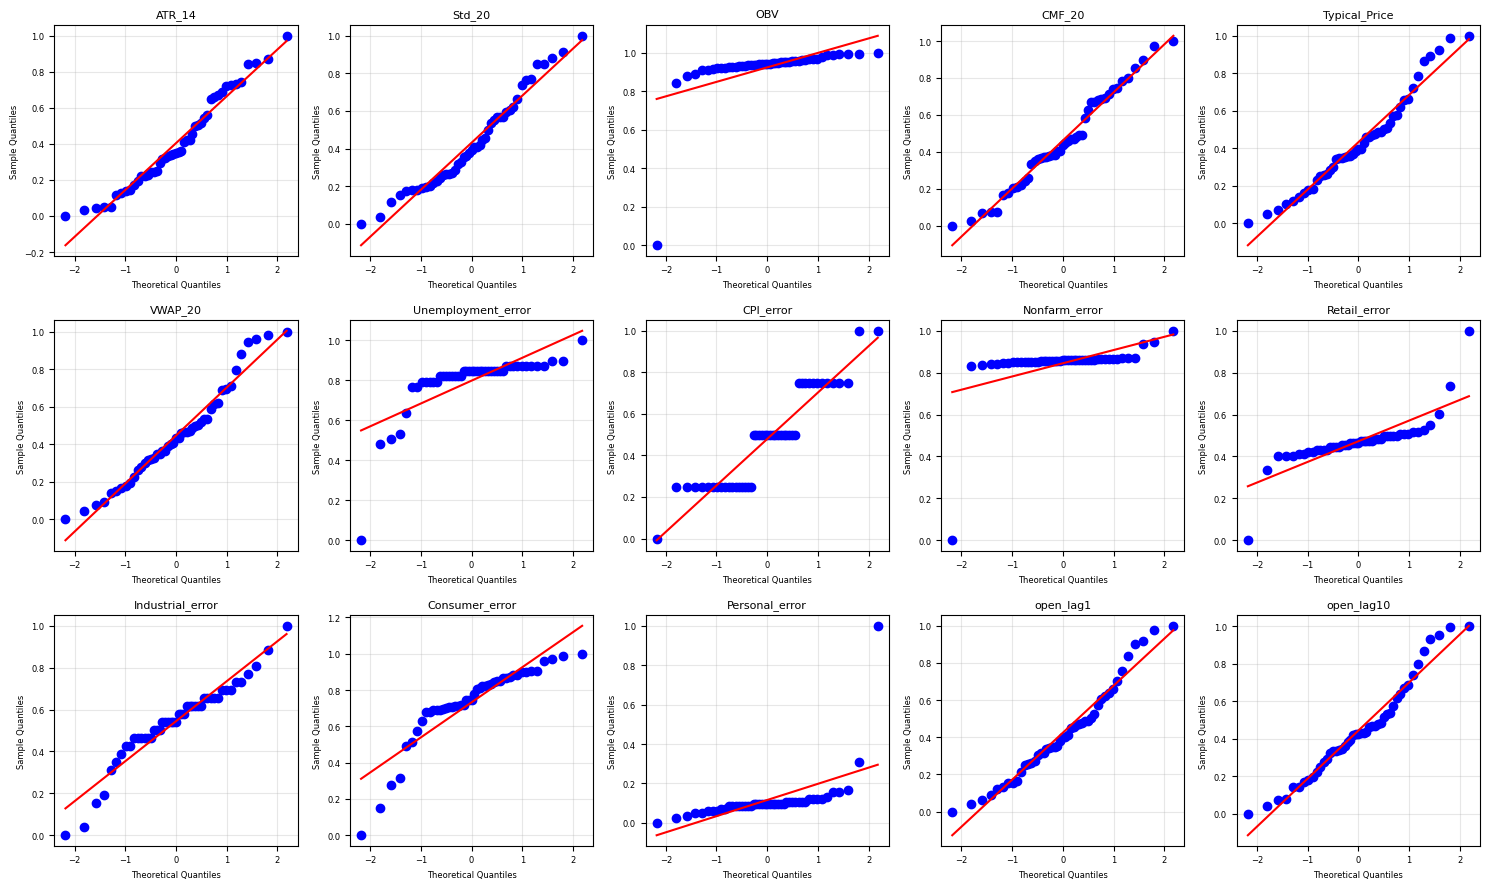

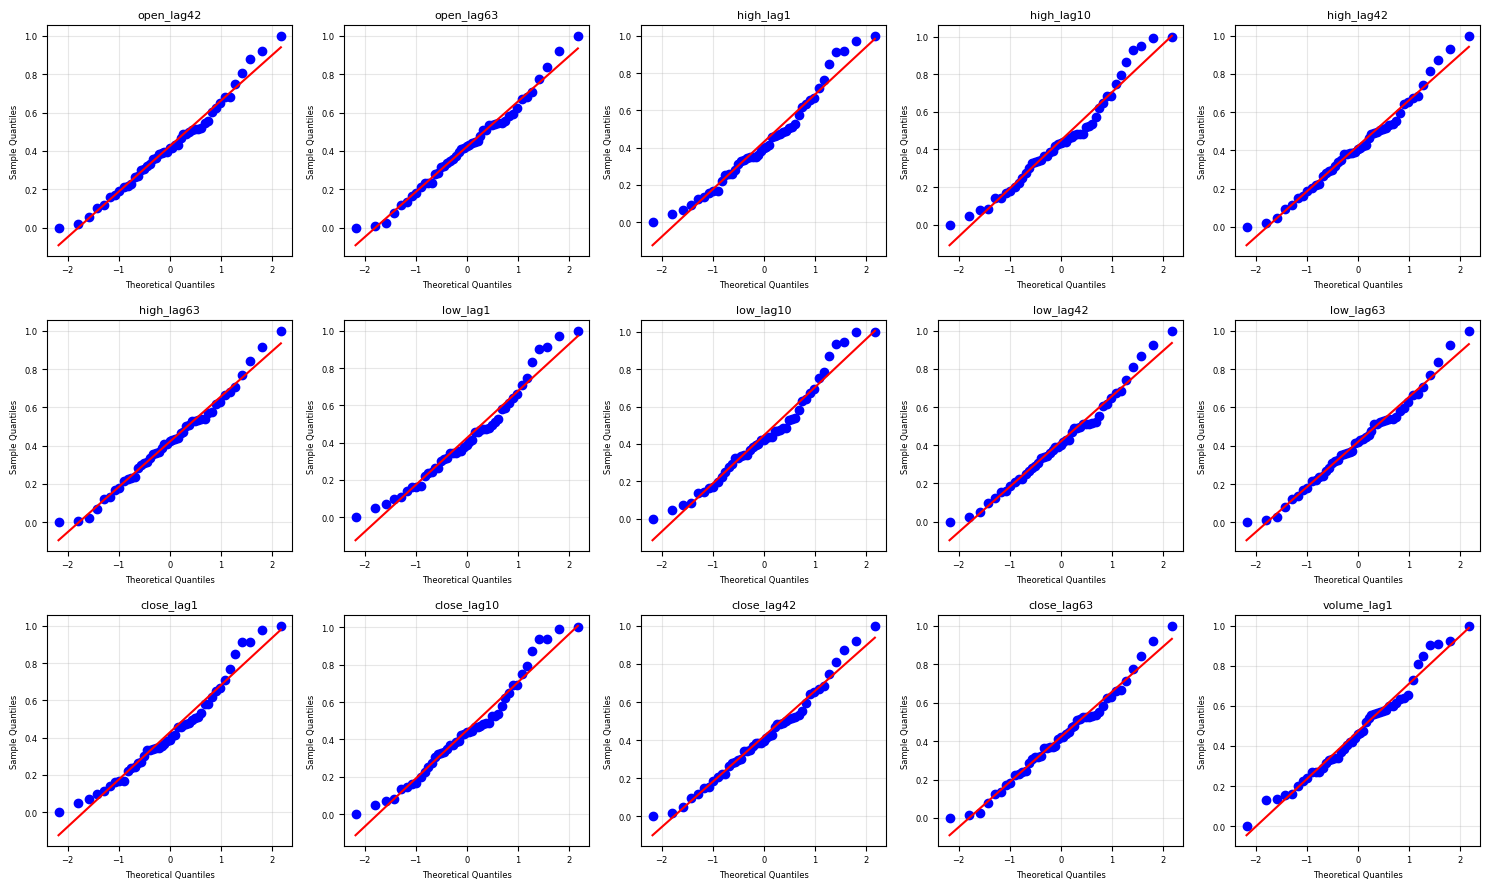

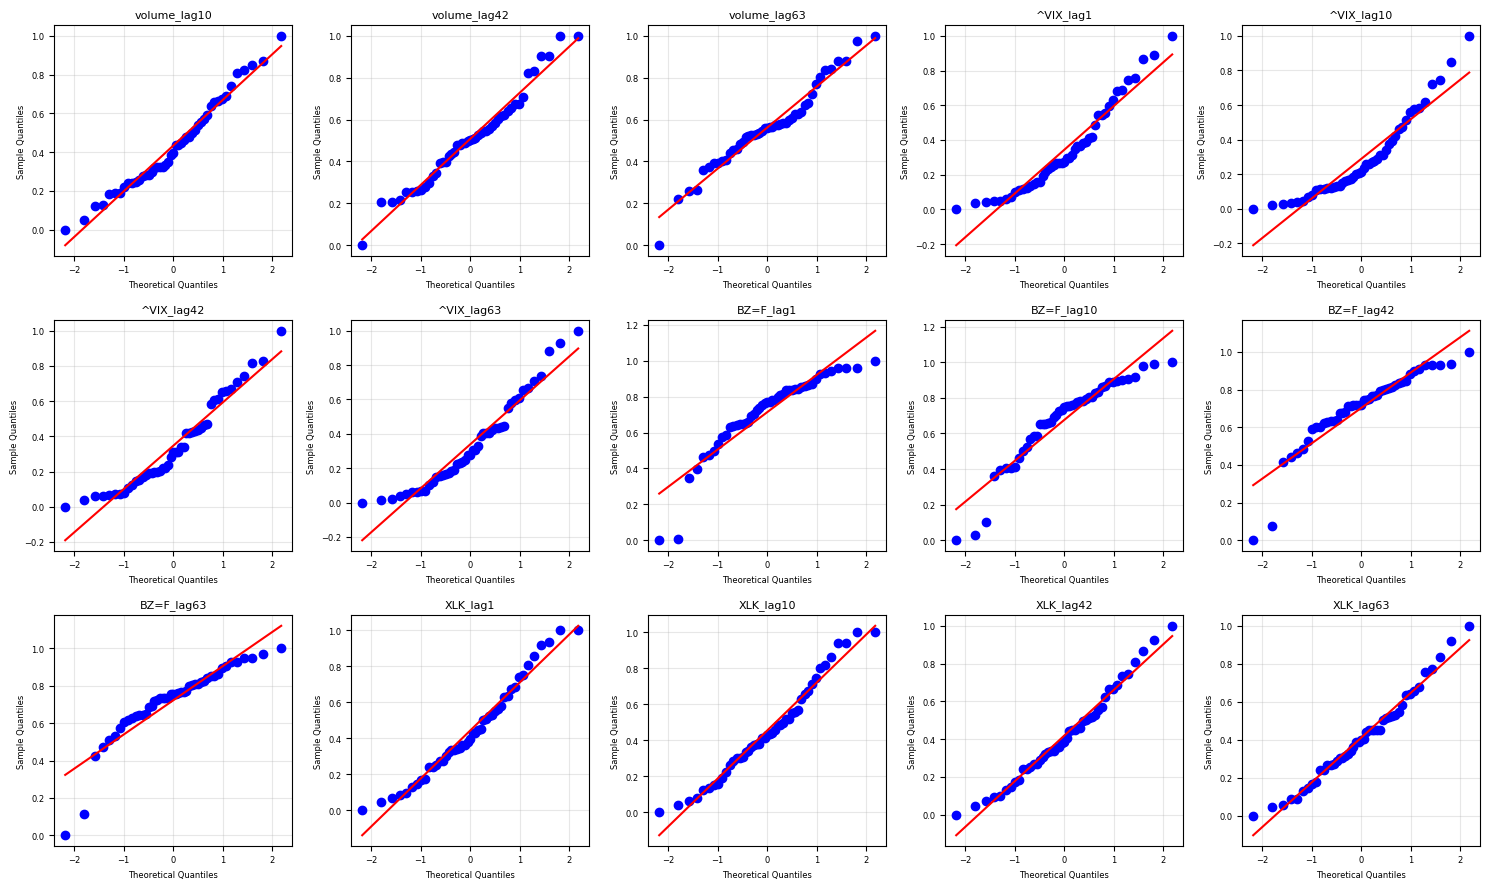

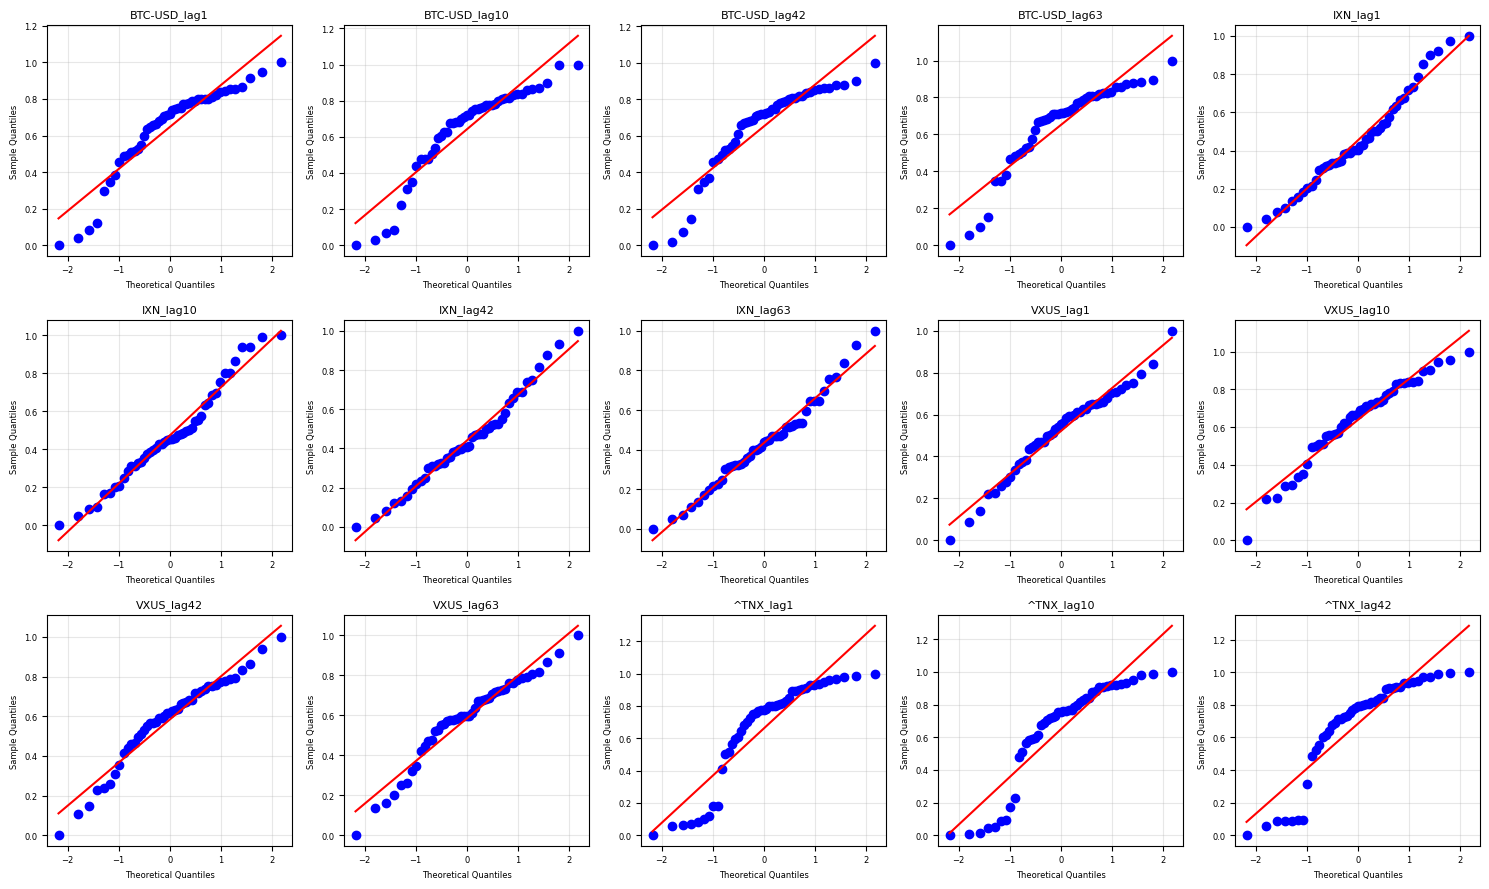

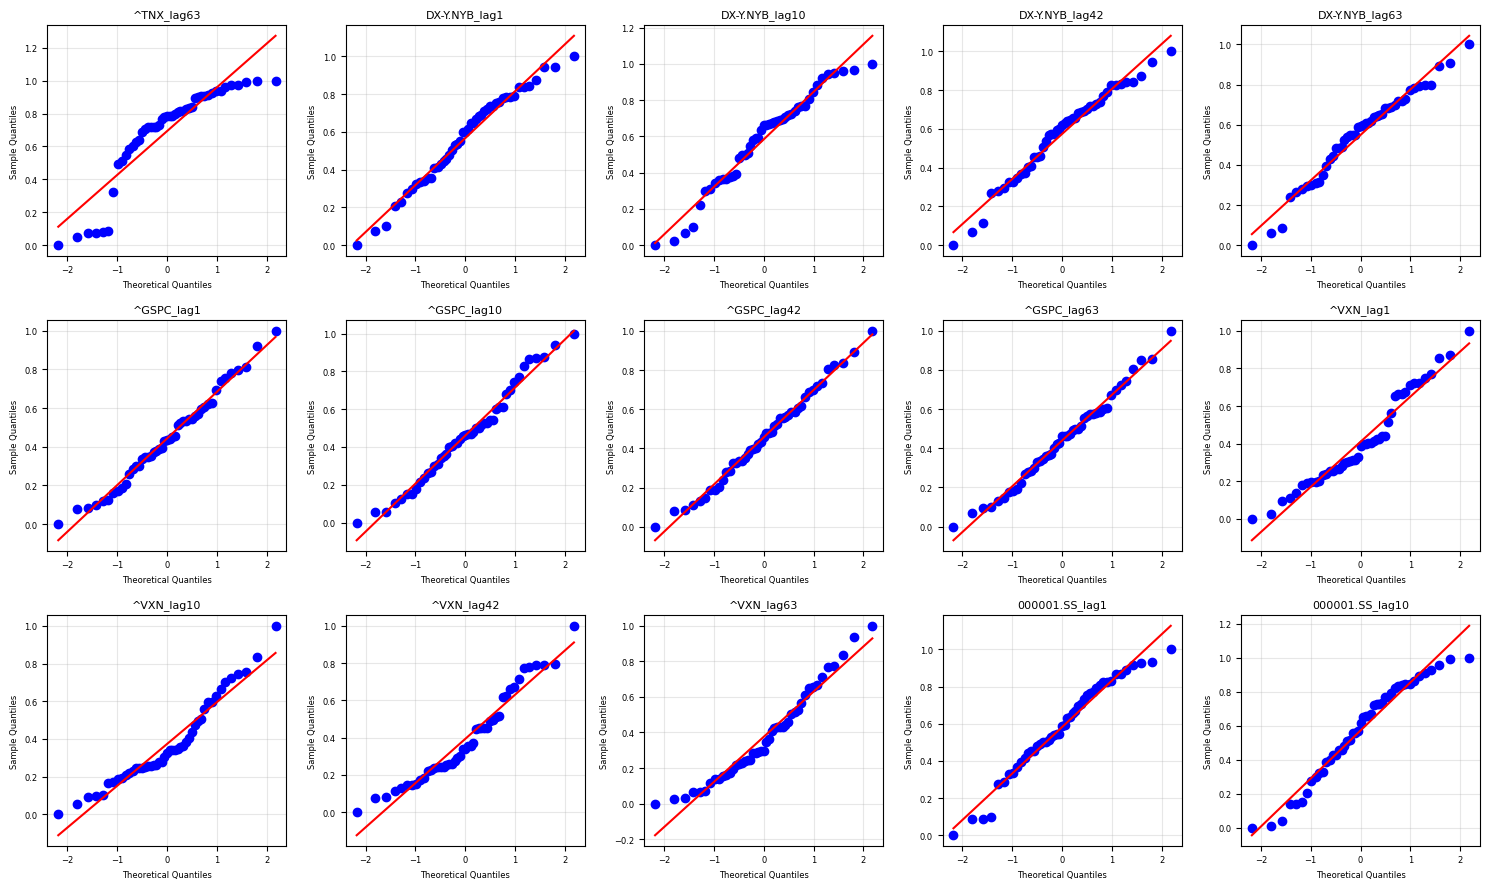

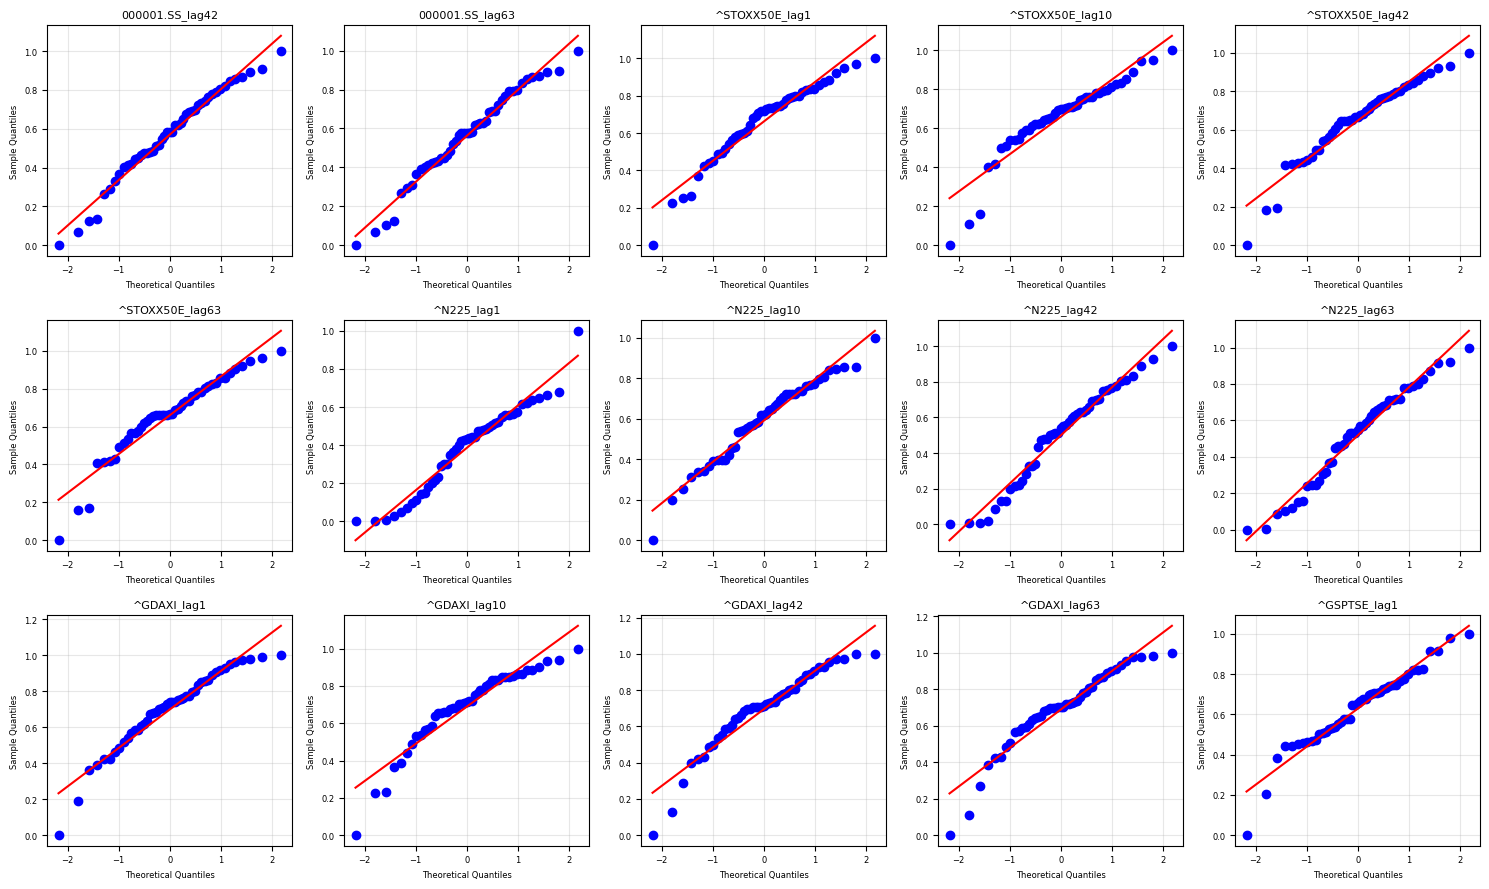

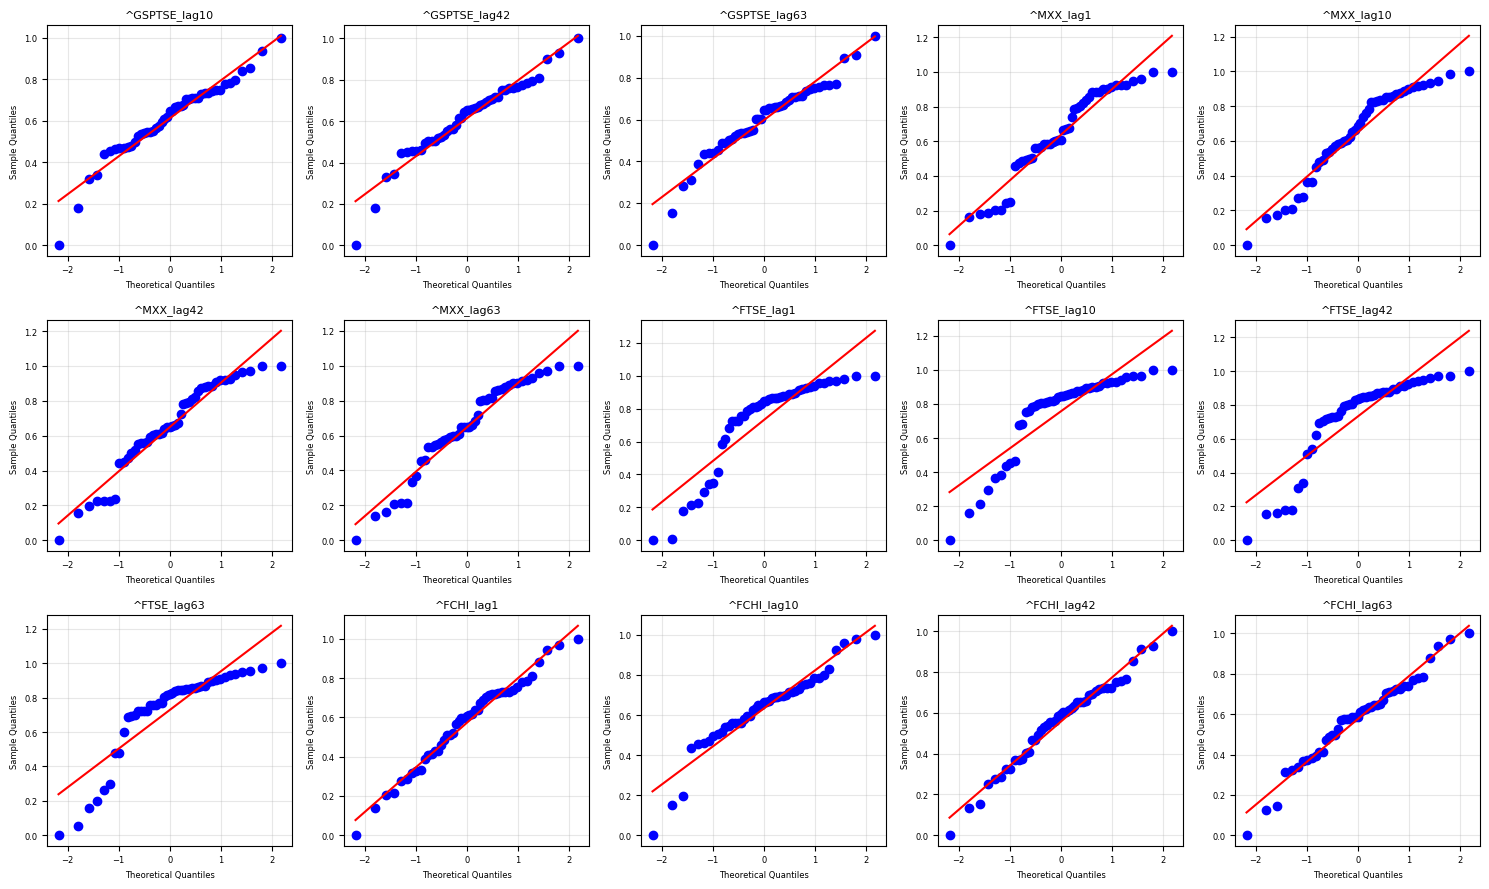

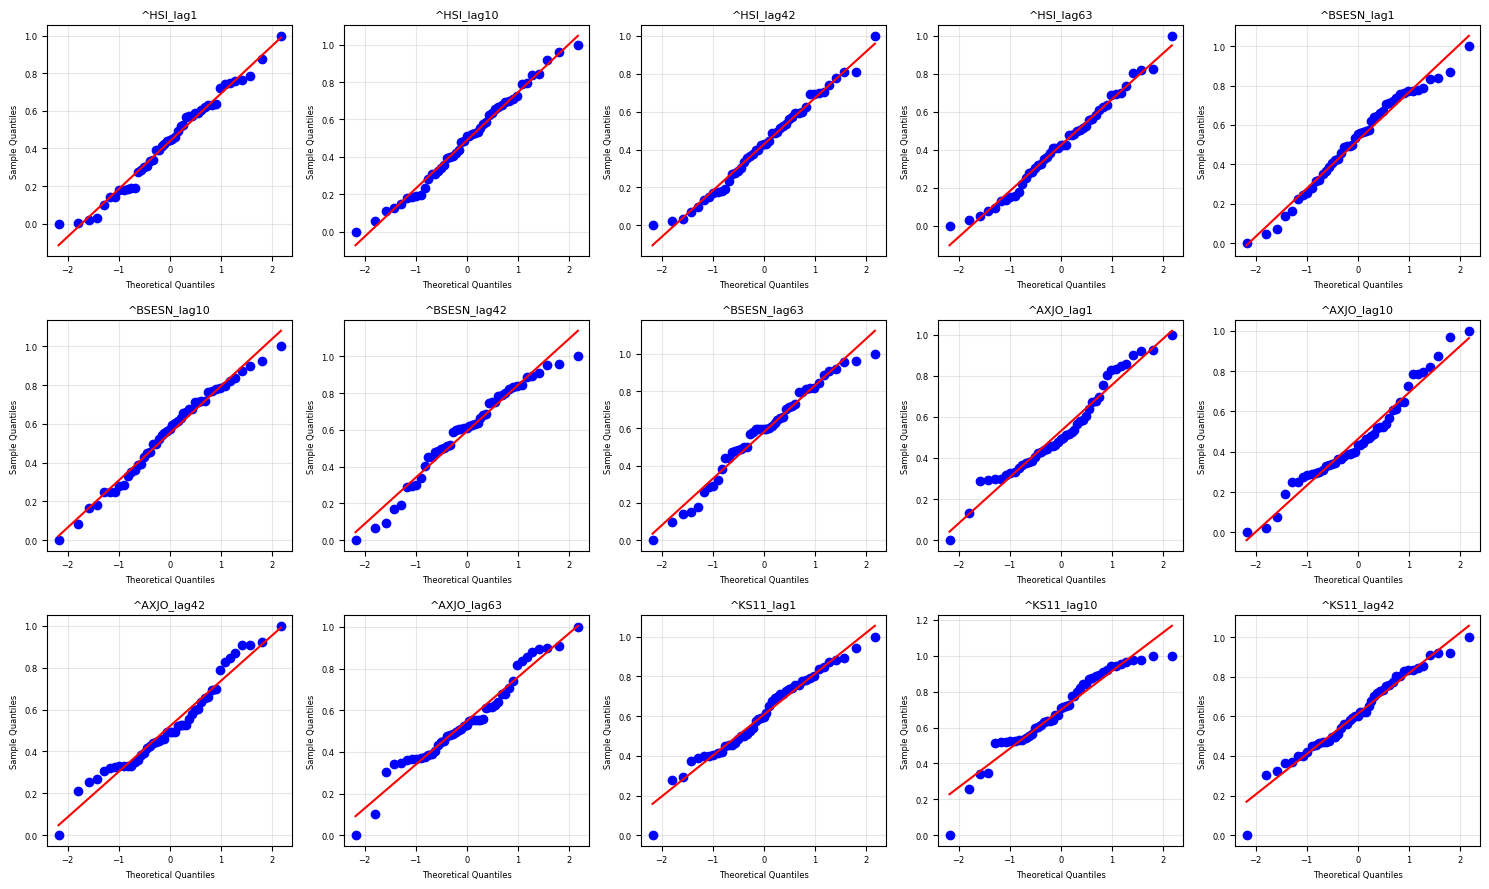

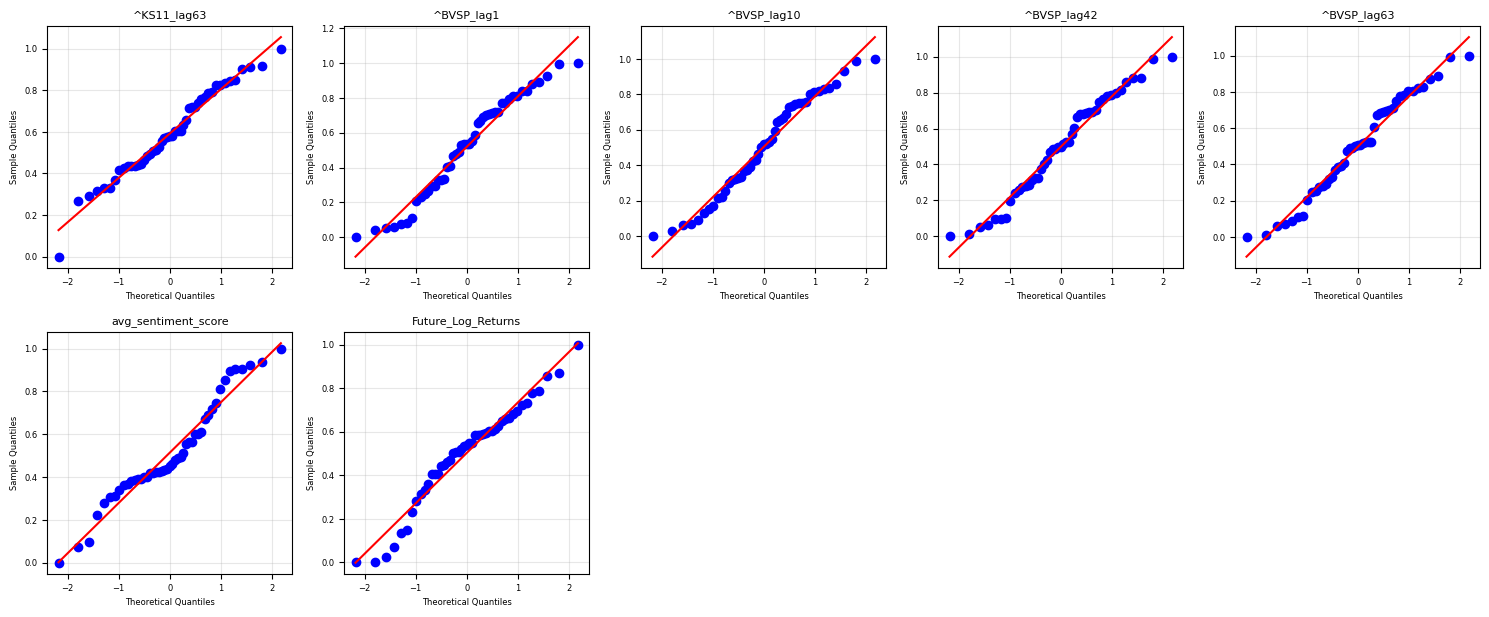

In [153]:
# Select numeric columns
numeric_df = scaled_df.select_dtypes(include=['int64', 'float64'])

# Get numerical columns
numerical_cols = numeric_df.columns

if not numerical_cols.size:
    print("No numerical columns found in the DataFrame.")
else:
    # Set grid parameters
    cols_per_figure = 5
    plots_per_figure = 15  # Number of plots per figure (adjustable)
    rows_per_figure = (plots_per_figure + cols_per_figure - 1) // cols_per_figure  # Ceiling division
    
    # Calculate number of figures needed
    num_figures = (len(numerical_cols) + plots_per_figure - 1) // plots_per_figure
    
    for fig_num in range(num_figures):
        start_idx = fig_num * plots_per_figure
        end_idx = min((fig_num + 1) * plots_per_figure, len(numerical_cols))
        current_cols = numerical_cols[start_idx:end_idx]
        
        if not current_cols.size:
            break
        
        # Create a new figure with dynamic rows
        fig, axes = plt.subplots(rows_per_figure, cols_per_figure, figsize=(15, 3 * rows_per_figure))
        axes = axes.flatten()  # Flatten for easier indexing
        
        for i, col in enumerate(current_cols):
            ax = axes[i]
            # Generate Q-Q plot
            probplot(numeric_df[col].dropna(), dist="norm", plot=ax)
            ax.set_title(col, fontsize=8)
            ax.set_xlabel('Theoretical Quantiles', fontsize=6)
            ax.set_ylabel('Sample Quantiles', fontsize=6)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', labelsize=6)
        
        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        # Adjust layout and display
        plt.tight_layout()
        plt.show()

# Train Test Split

In [154]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit


In [181]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Assume scaled_df is your DataFrame
print("Initial columns:", scaled_df.columns.tolist())
print("Initial dtypes:\n", scaled_df.dtypes)

# Convert Period columns to numerical values
for col in scaled_df.columns:
    if pd.api.types.is_period_dtype(scaled_df[col]):
        scaled_df[col] = scaled_df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)

# Select numerical columns, excluding 'Future_Log_Returns'
numerical_cols = scaled_df.select_dtypes(include=['float64', 'int64']).columns
if 'Future_Log_Returns' in numerical_cols:
    numerical_cols = numerical_cols.drop('Future_Log_Returns')
print("Numerical columns:", numerical_cols.tolist())

# Handle NaNs
scaled_df[numerical_cols] = scaled_df[numerical_cols].fillna(method='ffill').fillna(0)

# Step 1: Data Preparation
seq_len = 5
n_features = len(numerical_cols)

# Create sequences
X_seq = []
y_seq = []
for i in range(seq_len, len(scaled_df)):
    X_seq.append(scaled_df.iloc[i-seq_len:i][numerical_cols].values)
    y_seq.append(scaled_df.iloc[i]['Future_Log_Returns'])
X_seq = np.array(X_seq, dtype=float)
y_seq = np.array(y_seq, dtype=float)

# Validate data
if X_seq.dtype == object:
    raise ValueError("X_seq contains non-numerical data")
if not np.all(np.isfinite(X_seq)):
    raise ValueError("X_seq contains NaN or infinite values")
if not np.all(np.isfinite(y_seq)):
    raise ValueError("y_seq contains NaN or infinite values")

# Split into training and testing sets (time-based)
train_size = int(0.8 * len(X_seq))
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

# Step 2: Model Definitions
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VanillaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)  # concatenate forward and backward
        x = self.fc(h_n)
        return x

class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len) for Conv1d
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # (batch, seq_len, 64) for LSTM
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

# Training function for PyTorch models
def train_pytorch_model(model, X_train, y_train, epochs=50, batch_size=16):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

# Prediction function for PyTorch models
def predict_pytorch_model(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        outputs = model(X_tensor)
        return outputs.numpy().flatten()

# Step 3: Define models
models = [
    ('Baseline', LinearRegression(), 'sklearn'),
    ('Vanilla LSTM', lambda: VanillaLSTM(input_size=n_features, hidden_size=50, num_layers=1, output_size=1), 'pytorch'),
    ('Stacked LSTM', lambda: VanillaLSTM(input_size=n_features, hidden_size=50, num_layers=2, output_size=1), 'pytorch'),
    ('Bidirectional LSTM', lambda: BidirectionalLSTM(input_size=n_features, hidden_size=50, num_layers=1, output_size=1), 'pytorch'),
    ('CNN-LSTM', lambda: CNNLSTM(input_size=n_features, hidden_size=50, num_layers=1, output_size=1), 'pytorch')
]

# Step 4: Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
results = {'Model': [], 'Fold': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for name, model, model_type in models:
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]
        
        if model_type == 'sklearn':
            X_train_lr_fold = X_train_fold[:, -1, :]  # last time step
            X_val_lr_fold = X_val_fold[:, -1, :]
            model.fit(X_train_lr_fold, y_train_fold)
            y_pred = model.predict(X_val_lr_fold)
        else:
            model_instance = model()
            train_pytorch_model(model_instance, X_train_fold, y_train_fold)
            y_pred = predict_pytorch_model(model_instance, X_val_fold)
        
        # Compute metrics
        mse = mean_squared_error(y_val_fold, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        
        # Store results
        results['Model'].append(name)
        results['Fold'].append(fold)
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
        results['MAE'].append(mae)
        results['R2'].append(r2)

# Summarize CV results
results_df = pd.DataFrame(results)
summary = results_df.groupby('Model').agg({'MSE': ['mean', 'std'], 'RMSE': ['mean', 'std'], 'MAE': ['mean', 'std'], 'R2': ['mean', 'std']})
print("Cross-Validation Summary:")
print(summary)

# Step 5: Select best model based on R²
best_model_name = summary['MSE']['mean'].idxmin()
print(f"\nBest model based on MSE: {best_model_name}")

# Step 6: Train best model on full training set and evaluate on test set
best_model_type = [m[2] for m in models if m[0] == best_model_name][0]
best_model = [m[1] for m in models if m[0] == best_model_name][0]

if best_model_type == 'sklearn':
    X_train_lr_full = X_train[:, -1, :]
    X_test_lr_full = X_test[:, -1, :]
    best_model.fit(X_train_lr_full, y_train)
    y_pred = best_model.predict(X_test_lr_full)
else:
    model_instance = best_model()
    train_pytorch_model(model_instance, X_train, y_train)
    y_pred = predict_pytorch_model(model_instance, X_test)

# Compute test metrics
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"\nTest performance of {best_model_name}:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R2: {test_r2:.4f}")

Initial columns: ['open', 'high', 'low', 'close', 'volume', 'month_year', 'Unemployment_Actual', 'Unemployment_Predicted', 'CPI_Actual', 'CPI_Predicted', 'Nonfarm_Payrolls_Actual', 'Nonfarm_Payrolls_Predicted', 'Retail_Sales_Actual', 'Retail_Sales_Predicted', 'Industrial_Production_Actual', 'Industrial_Production_Predicted', 'Consumer_Confidence_Index_Actual', 'Consumer_Confidence_Index_Predicted', 'Personal_Income_Actual', 'Personal_Income_Predicted', '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS', '^TNX', 'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS', '^STOXX50E', '^N225', '^GDAXI', '^GSPTSE', '^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'MACD', 'MACD_signal', 'MACD_histogram', 'RSI_14', 'RSI_7', 'Stoch_%K', 'Stoch_%D', 'ROC_10', 'ROC_21', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ATR_14', 'Std_20', 'OBV', 'CMF_20', 'Typical_Price', 'VWAP_20', 'Unemployment_error', 'CPI_error', 'Nonfarm_error', 'Retail_error

In [189]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Assume scaled_df is your DataFrame
print("Initial columns:", scaled_df.columns.tolist())
print("Initial dtypes:\n", scaled_df.dtypes)

# Convert Period columns to numerical values
for col in scaled_df.columns:
    if pd.api.types.is_period_dtype(scaled_df[col]):
        scaled_df[col] = scaled_df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)

# Select numerical columns, excluding 'Future_Log_Returns'
numerical_cols = scaled_df.select_dtypes(include=['float64', 'int64']).columns
if 'Future_Log_Returns' in numerical_cols:
    numerical_cols = numerical_cols.drop('Future_Log_Returns')
print("Numerical columns:", numerical_cols.tolist())

# Handle NaNs
scaled_df[numerical_cols] = scaled_df[numerical_cols].fillna(method='ffill').fillna(0)

# Step 1: Data Preparation
seq_len = 5
n_features = len(numerical_cols)

# Create sequences
X_seq = []
y_seq = []
for i in range(seq_len, len(scaled_df)):
    X_seq.append(scaled_df.iloc[i-seq_len:i][numerical_cols].values)
    y_seq.append(scaled_df.iloc[i]['Future_Log_Returns'])
X_seq = np.array(X_seq, dtype=float)
y_seq = np.array(y_seq, dtype=float)

# Validate data
if X_seq.dtype == object:
    raise ValueError("X_seq contains non-numerical data")
if not np.all(np.isfinite(X_seq)):
    raise ValueError("X_seq contains NaN or infinite values")
if not np.all(np.isfinite(y_seq)):
    raise ValueError("y_seq contains NaN or infinite values")

# Split into training and testing sets (time-based)
train_size = int(0.8 * len(X_seq))
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

# Apply RFECV for feature selection
# Extract features from the last time step for RFECV
X_train_last = X_train[:, -1, :]  # Shape: (train_samples, n_features)

# Define the estimator and cross-validation strategy
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
rfecv = RFECV(estimator, step=1, cv=tscv, scoring='neg_mean_squared_error')

# Fit RFECV on training data (last time step)
rfecv.fit(X_train_last, y_train)

# Get feature selection results
selected_mask = rfecv.support_
selected_indices = np.where(selected_mask)[0]
n_selected = len(selected_indices)
n_dropped = n_features - n_selected
selected_features = numerical_cols[selected_mask]

# Get feature importances for the selected features from the final estimator
importances = rfecv.estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Report results
print(f"\nNumber of features selected: {n_selected}")
print(f"Number of features dropped: {n_dropped}")
print("Top-ranked features (sorted by importance):")
print(feature_importance_df)

# Apply selected features to training and testing sequences
X_train_selected = X_train[:, :, selected_indices]
X_test_selected = X_test[:, :, selected_indices]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # Shuffle=False for time series

# Define CNN-LSTM Model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len) for Conv1d
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # (batch, seq_len, 64) for LSTM
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

# Initialize model with the number of selected features as input size
model = CNNLSTM(input_size=n_selected, hidden_size=50, num_layers=1, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()
    y_test = y_test_tensor.numpy().flatten()

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Initial columns: ['open', 'high', 'low', 'close', 'volume', 'month_year', 'Unemployment_Actual', 'Unemployment_Predicted', 'CPI_Actual', 'CPI_Predicted', 'Nonfarm_Payrolls_Actual', 'Nonfarm_Payrolls_Predicted', 'Retail_Sales_Actual', 'Retail_Sales_Predicted', 'Industrial_Production_Actual', 'Industrial_Production_Predicted', 'Consumer_Confidence_Index_Actual', 'Consumer_Confidence_Index_Predicted', 'Personal_Income_Actual', 'Personal_Income_Predicted', '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS', '^TNX', 'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS', '^STOXX50E', '^N225', '^GDAXI', '^GSPTSE', '^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'MACD', 'MACD_signal', 'MACD_histogram', 'RSI_14', 'RSI_7', 'Stoch_%K', 'Stoch_%D', 'ROC_10', 'ROC_21', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ATR_14', 'Std_20', 'OBV', 'CMF_20', 'Typical_Price', 'VWAP_20', 'Unemployment_error', 'CPI_error', 'Nonfarm_error', 'Retail_error

In [190]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Assume scaled_df is your DataFrame
print("Initial columns:", scaled_df.columns.tolist())
print("Initial dtypes:\n", scaled_df.dtypes)

# Convert Period columns to numerical values
for col in scaled_df.columns:
    if pd.api.types.is_period_dtype(scaled_df[col]):
        scaled_df[col] = scaled_df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)

# Select numerical columns, excluding 'Future_Log_Returns'
numerical_cols = scaled_df.select_dtypes(include=['float64', 'int64']).columns
if 'Future_Log_Returns' in numerical_cols:
    numerical_cols = numerical_cols.drop('Future_Log_Returns')
print("Numerical columns:", numerical_cols.tolist())

# Handle NaNs
scaled_df[numerical_cols] = scaled_df[numerical_cols].fillna(method='ffill').fillna(0)

# Step 1: Data Preparation
seq_len = 5
n_features = len(numerical_cols)

# Create sequences
X_seq = []
y_seq = []
for i in range(seq_len, len(scaled_df)):
    X_seq.append(scaled_df.iloc[i-seq_len:i][numerical_cols].values)
    y_seq.append(scaled_df.iloc[i]['Future_Log_Returns'])
X_seq = np.array(X_seq, dtype=float)
y_seq = np.array(y_seq, dtype=float)

# Validate data
if X_seq.dtype == object:
    raise ValueError("X_seq contains non-numerical data")
if not np.all(np.isfinite(X_seq)):
    raise ValueError("X_seq contains NaN or infinite values")
if not np.all(np.isfinite(y_seq)):
    raise ValueError("y_seq contains NaN or infinite values")

# Split into training and testing sets (time-based)
train_size = int(0.8 * len(X_seq))
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

# Apply RFECV for feature selection
X_train_last = X_train[:, -1, :]  # Shape: (train_samples, n_features)
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
rfecv = RFECV(estimator, step=1, cv=tscv, scoring='neg_mean_squared_error')
rfecv.fit(X_train_last, y_train)

# Get feature selection results
selected_mask = rfecv.support_
selected_indices = np.where(selected_mask)[0]
n_selected = len(selected_indices)
n_dropped = n_features - n_selected
selected_features = numerical_cols[selected_mask]

# Get feature importances
importances = rfecv.estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Report results
print(f"\nNumber of features selected: {n_selected}")
print(f"Number of features dropped: {n_dropped}")
print("Top-ranked features (sorted by importance):")
print(feature_importance_df)

# Apply selected features to sequences
X_train_selected = X_train[:, :, selected_indices]
X_test_selected = X_test[:, :, selected_indices]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Define CNN-LSTM Model with customizable activation
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, activation):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.activation = activation
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.conv1(x)
        x = self.activation(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, 64)
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

# Function to train and evaluate the model
def train_and_evaluate(activation_name, activation_func):
    print(f"\nTraining with {activation_name} activation...")
    
    model = CNNLSTM(input_size=n_selected, hidden_size=50, num_layers=1, output_size=1, activation=activation_func)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training Loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()
        y_test = y_test_tensor.numpy().flatten()
    
    # Performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nTest Performance with {activation_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return mse, rmse, mae, r2

# Define activation functions to test
activations = {
    'ReLU': torch.relu,
    'Tanh': torch.tanh,
    'Sigmoid': torch.sigmoid,
    'LeakyReLU': nn.LeakyReLU(negative_slope=0.01)
}

# Store results
results = {}

# Run experiments
for name, func in activations.items():
    metrics = train_and_evaluate(name, func)
    results[name] = metrics

# Compare results
print("\nComparison of Activation Functions:")
for name, (mse, rmse, mae, r2) in results.items():
    print(f"{name}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

Initial columns: ['open', 'high', 'low', 'close', 'volume', 'month_year', 'Unemployment_Actual', 'Unemployment_Predicted', 'CPI_Actual', 'CPI_Predicted', 'Nonfarm_Payrolls_Actual', 'Nonfarm_Payrolls_Predicted', 'Retail_Sales_Actual', 'Retail_Sales_Predicted', 'Industrial_Production_Actual', 'Industrial_Production_Predicted', 'Consumer_Confidence_Index_Actual', 'Consumer_Confidence_Index_Predicted', 'Personal_Income_Actual', 'Personal_Income_Predicted', '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS', '^TNX', 'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS', '^STOXX50E', '^N225', '^GDAXI', '^GSPTSE', '^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'MACD', 'MACD_signal', 'MACD_histogram', 'RSI_14', 'RSI_7', 'Stoch_%K', 'Stoch_%D', 'ROC_10', 'ROC_21', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ATR_14', 'Std_20', 'OBV', 'CMF_20', 'Typical_Price', 'VWAP_20', 'Unemployment_error', 'CPI_error', 'Nonfarm_error', 'Retail_error

Initial columns: ['open', 'high', 'low', 'close', 'volume', 'month_year', 'Unemployment_Actual', 'Unemployment_Predicted', 'CPI_Actual', 'CPI_Predicted', 'Nonfarm_Payrolls_Actual', 'Nonfarm_Payrolls_Predicted', 'Retail_Sales_Actual', 'Retail_Sales_Predicted', 'Industrial_Production_Actual', 'Industrial_Production_Predicted', 'Consumer_Confidence_Index_Actual', 'Consumer_Confidence_Index_Predicted', 'Personal_Income_Actual', 'Personal_Income_Predicted', '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS', '^TNX', 'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS', '^STOXX50E', '^N225', '^GDAXI', '^GSPTSE', '^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'MACD', 'MACD_signal', 'MACD_histogram', 'RSI_14', 'RSI_7', 'Stoch_%K', 'Stoch_%D', 'ROC_10', 'ROC_21', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ATR_14', 'Std_20', 'OBV', 'CMF_20', 'Typical_Price', 'VWAP_20', 'Unemployment_error', 'CPI_error', 'Nonfarm_error', 'Retail_error

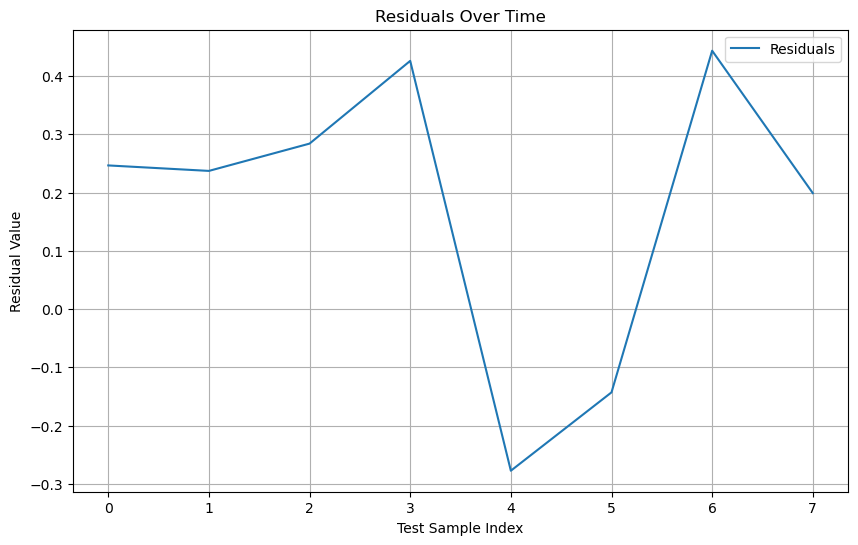

In [191]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Assume scaled_df is your DataFrame
print("Initial columns:", scaled_df.columns.tolist())
print("Initial dtypes:\n", scaled_df.dtypes)

# Convert Period columns to numerical values
for col in scaled_df.columns:
    if pd.api.types.is_period_dtype(scaled_df[col]):
        scaled_df[col] = scaled_df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)

# Select numerical columns, excluding 'Future_Log_Returns'
numerical_cols = scaled_df.select_dtypes(include=['float64', 'int64']).columns
if 'Future_Log_Returns' in numerical_cols:
    numerical_cols = numerical_cols.drop('Future_Log_Returns')
print("Numerical columns:", numerical_cols.tolist())

# Improve Preprocessing: Handle outliers using IQR method and verify scaling
for col in numerical_cols:
    q1, q3 = scaled_df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    scaled_df[col] = scaled_df[col].clip(lower_bound, upper_bound)

# Handle NaNs with forward fill and fallback to 0
scaled_df[numerical_cols] = scaled_df[numerical_cols].fillna(method='ffill').fillna(0)

# Step 1: Data Preparation with increased sequence length
seq_len = 10  # Increased from 5 to capture longer dependencies
n_features = len(numerical_cols)

# Create sequences
X_seq = []
y_seq = []
for i in range(seq_len, len(scaled_df)):
    X_seq.append(scaled_df.iloc[i-seq_len:i][numerical_cols].values)
    y_seq.append(scaled_df.iloc[i]['Future_Log_Returns'])
X_seq = np.array(X_seq, dtype=float)
y_seq = np.array(y_seq, dtype=float)

# Validate data
if X_seq.dtype == object:
    raise ValueError("X_seq contains non-numerical data")
if not np.all(np.isfinite(X_seq)):
    raise ValueError("X_seq contains NaN or infinite values")
if not np.all(np.isfinite(y_seq)):
    raise ValueError("y_seq contains NaN or infinite values")

# Split into training and testing sets (time-based)
train_size = int(0.8 * len(X_seq))
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

# Refine Features: Use RFECV and select top 50 features
X_train_last = X_train[:, -1, :]  # Shape: (train_samples, n_features)
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
rfecv = RFECV(estimator, step=1, cv=tscv, scoring='neg_mean_squared_error')
rfecv.fit(X_train_last, y_train)

# Get feature selection results and importance
selected_mask = rfecv.support_
selected_features = numerical_cols[selected_mask]
importances = rfecv.estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Select top 50 features
top_n = 50
top_features = feature_importance_df.head(top_n)['feature'].tolist()
selected_indices = [list(numerical_cols).index(feat) for feat in top_features]
X_train_selected = X_train[:, :, selected_indices]
X_test_selected = X_test[:, :, selected_indices]
n_selected = len(selected_indices)

print(f"\nNumber of features selected: {n_selected}")
print("Top-ranked features (sorted by importance):")
print(feature_importance_df.head(top_n))

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader with tuned batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # Increased batch size

# Enhance Model: Define CNN-LSTM with additional layers and dropout
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)  # Added second conv layer
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)  # Regularization with dropout
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, 128)
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

# Initialize model with tuned hyperparameters
model = CNNLSTM(input_size=n_selected, hidden_size=100, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # L2 regularization

# Training Loop with early stopping
num_epochs = 50
patience = 5
best_loss = float('inf')
trigger = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    # Validate Properly: Simple validation using test set (could expand to full CV)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()
        val_loss = mean_squared_error(y_test, y_pred)
        if val_loss < best_loss:
            best_loss = val_loss
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("Early stopping triggered")
                break

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()
    y_test = y_test_tensor.numpy().flatten()

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Analyze Errors: Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title("Residuals Over Time")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual Value")
plt.legend()
plt.grid(True)
plt.savefig('residuals_plot.png')

In [124]:
from sklearn.preprocessing import MinMaxScaler

In [121]:
rng = np.random.RandomState(42)
mask = rng.rand(len(outliner_df)) < 0.8
train_data = scaled_df[mask]
test_data = scaled_df[~mask]
print('Training dataset length: '+str(len(train_data)))
print('Testing dataset length: '+str(len(test_data)))

Training dataset length: 39
Testing dataset length: 8


In [122]:
# Define the dependent and independent variables
y_train = train_data['Future_Log_Returns']
X_train = train_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')

y_test = test_data['Future_Log_Returns']
X_test = test_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')

In [125]:
# Preprocess: Scale features
scaler = MinMaxScaler(feature_range=(0, 1))  # Fixed syntax
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_features = X_train.shape[1]

array([[ 0.05184134,  0.05038661,  0.0509876 , ...,  0.52353913,
         0.51829449,  0.92446968],
       [ 0.1743177 ,  0.18099223,  0.18061477, ...,  0.01457673,
        -0.01014101,  0.49519674],
       [ 0.26512205,  0.26329136,  0.26482029, ...,  0.28448578,
         0.27215043,  0.90346655],
       ...,
       [ 0.57853532,  0.57803589,  0.58763509, ...,  0.81718115,
         0.77633418,  0.39932919],
       [ 0.61269348,  0.61690946,  0.62330152, ...,  0.88335052,
         0.82283185,  0.60199377],
       [ 0.97663218,  0.98809051,  0.99178093, ...,  0.6905928 ,
         0.60454121,  0.4195688 ]])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Assuming train_data and test_data are pandas DataFrames with 'Future_Log_Returns' as the target
# Example: train_data = pd.read_csv('train.csv'), test_data = pd.read_csv('test.csv')

# Define dependent and independent variables
y_train = train_data['Future_Log_Returns']
X_train = train_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')
y_test = test_data['Future_Log_Returns']
X_test = test_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')

# Preprocess: Scale features
scaler = MinMaxScaler(feature_range=(0, 1))  # Fixed syntax
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_features = X_train.shape[1]

In [127]:
# **PyTorch Model Definitions**
class DNN(nn.Module):
    def __init__(self, n_features):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(n_features, 50, batch_first=True)
        self.fc = nn.Linear(50, 1)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

class CNN(nn.Module):
    def __init__(self, n_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)  # Input channels=1
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * n_features, 50)  # Maintain original calculation
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, features) to (batch, 1, features)
        x = torch.relu(self.conv1(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# **Training Function for PyTorch Models (Cross-Validation)**
def train_pytorch_model(model, model_name, X_train, y_train, X_val, y_val, epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    
    # Reshape inputs for LSTM and CNN
    if model_name == 'LSTM':
        X_train_tensor = X_train_tensor.unsqueeze(1)  # (batch, 1, features)
    elif model_name == 'CNN':
        X_train_tensor = X_train_tensor.unsqueeze(1)  # (batch, 1, features) instead of unsqueeze(2)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Validation predictions
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_pred = val_outputs.numpy().flatten()
    return val_pred

# **Training Function for PyTorch Models (Full Training Set)**
def train_pytorch_model_full(model, model_name, X_train, y_train, epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    
    if model_name == 'LSTM':
        X_train_tensor = X_train_tensor.unsqueeze(1)
    elif model_name == 'CNN':
        X_train_tensor = X_train_tensor.unsqueeze(2)
    
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

# **Compute Metrics**
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# **Configuration**
num_folds = 5
seed = 7
scaled_models = ['KNN', 'SVR', 'DNN', 'LSTM', 'CNN']
epochs = 50
batch_size = 32

# **Define Models**
models = [
    ('LR', LinearRegression(), 'sklearn'),
    ('KNN', KNeighborsRegressor(), 'sklearn'),
    ('CART', DecisionTreeRegressor(random_state=seed), 'sklearn'),
    ('RF', RandomForestRegressor(n_jobs=-1, random_state=seed), 'sklearn'),
    ('GB', GradientBoostingRegressor(random_state=seed), 'sklearn'),
    ('SVR', SVR(), 'sklearn'),
    ('DNN', lambda: DNN(n_features), 'pytorch'),
    ('LSTM', lambda: LSTMModel(n_features), 'pytorch'),
    ('CNN', lambda: CNN(n_features), 'pytorch')
]

# **Store Results**
results = {
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'R2': []
}

# **Cross-Validation**
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for name, model, model_type in models:
    if model_type == 'sklearn':
        # Use scaled data for models requiring scaling
        X_train_current = X_train_scaled if name in scaled_models else X_train
        cv_results = cross_validate(model, X_train_current, y_train, cv=kfold,
                                    scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                                             'neg_mean_absolute_error', 'r2'])
        fold_mse = -cv_results['test_neg_mean_squared_error']
        fold_rmse = -cv_results['test_neg_root_mean_squared_error']
        fold_mae = -cv_results['test_neg_mean_absolute_error']
        fold_r2 = cv_results['test_r2']
    elif model_type == 'pytorch':
        fold_mse, fold_rmse, fold_mae, fold_r2 = [], [], [], []
        for train_idx, val_idx in kfold.split(X_train_scaled):
            X_train_fold = X_train_scaled[train_idx]
            y_train_fold = y_train.values[train_idx]
            X_val_fold = X_train_scaled[val_idx]
            y_val_fold = y_train.values[val_idx]
            model_instance = model()  # Create new instance for each fold
            val_pred = train_pytorch_model(model_instance, name, X_train_fold, y_train_fold,
                                          X_val_fold, y_val_fold, epochs, batch_size)
            mse, rmse, mae, r2 = compute_metrics(y_val_fold, val_pred)
            fold_mse.append(mse)
            fold_rmse.append(rmse)
            fold_mae.append(mae)
            fold_r2.append(r2)
    
    # Store and display results
    results['MSE'].append(fold_mse)
    results['RMSE'].append(fold_rmse)
    results['MAE'].append(fold_mae)
    results['R2'].append(fold_r2)
    
    print(f"{name}:")
    print(f"  MSE: {np.mean(fold_mse):.3f} (±{np.std(fold_mse):.3f})")
    print(f"  RMSE: {np.mean(fold_rmse):.3f} (±{np.std(fold_rmse):.3f})")
    print(f"  MAE: {np.mean(fold_mae):.3f} (±{np.std(fold_mae):.3f})")
    print(f"  R2: {np.mean(fold_r2):.3f} (±{np.std(fold_r2):.3f})\n")

# **Visualize Results**
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
model_names = [name for name, _, _ in models]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.boxplot(results[metric])
    ax.set_title(f'{metric} Comparison Across Models')
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

# **Test Best Model**
best_idx = np.argmin([np.mean(scores) for scores in results['MSE']])
best_model_name, best_model, best_model_type = models[best_idx]

if best_model_type == 'sklearn':
    X_train_final = X_train_scaled if best_model_name in scaled_models else X_train
    X_test_final = X_test_scaled if best_model_name in scaled_models else X_test
    best_model.fit(X_train_final, y_train)
    y_pred = best_model.predict(X_test_final)
elif best_model_type == 'pytorch':
    model_instance = best_model()
    train_pytorch_model_full(model_instance, best_model_name, X_train_scaled, y_train.values, epochs, batch_size)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    if best_model_name == 'LSTM':
        X_test_tensor = X_test_tensor.unsqueeze(1)
    elif best_model_name == 'CNN':
        X_test_tensor = X_test_tensor.unsqueeze(2)
    model_instance.eval()
    with torch.no_grad():
        y_pred = model_instance(X_test_tensor).numpy().flatten()

# **Test Set Performance**
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Best Model ({best_model_name}) Test Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R2: {test_r2:.4f}")

LR:
  MSE: 0.046 (±0.025)
  RMSE: 0.208 (±0.055)
  MAE: 0.153 (±0.021)
  R2: 0.134 (±0.367)

KNN:
  MSE: 0.056 (±0.011)
  RMSE: 0.236 (±0.024)
  MAE: 0.191 (±0.030)
  R2: -0.077 (±0.237)

CART:
  MSE: 0.074 (±0.035)
  RMSE: 0.266 (±0.059)
  MAE: 0.228 (±0.055)
  R2: -0.385 (±0.496)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. Thi

RF:
  MSE: 0.050 (±0.019)
  RMSE: 0.221 (±0.042)
  MAE: 0.167 (±0.048)
  R2: 0.066 (±0.250)

GB:
  MSE: 0.061 (±0.017)
  RMSE: 0.244 (±0.034)
  MAE: 0.195 (±0.036)
  R2: -0.136 (±0.225)

SVR:
  MSE: 0.051 (±0.012)
  RMSE: 0.224 (±0.029)
  MAE: 0.178 (±0.041)
  R2: 0.032 (±0.232)

DNN:
  MSE: 0.061 (±0.017)
  RMSE: 0.244 (±0.034)
  MAE: 0.198 (±0.041)
  R2: -0.150 (±0.254)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/02/hv2vnm3n0d35b_wnxjv6zgj00000gn/T/ipykernel_2242/339995027.py", line 162, in <module>
    mse, rmse, mae, r2 = compute_metrics(y_val_fold, val_pred)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/02/hv2vnm3n0d35b_wnxjv6zgj00000gn/T/ipykernel_2242/339995027.py", line 104, in compute_metrics
    mse = mean_squared_error(y_true, y_pred)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    prefer_skip_nested_validation or global_skip_validation
       ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 497, in mean_squared_error
  File "/opt/anaconda3/lib/python3.11/site-p

In [104]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers.scikit_learn'

In [103]:
! pip install --upgrade tensorflow keras scikit-learn

# Then use this alternative approach
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

# Create model directly without KerasRegressor
model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 877.3 kB/s eta 0:00:0000:0100:07
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 877.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 829.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.4/671.4 kB 885.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 922.6 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: scikit-lea

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 186)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 186), dtype=float32)
  • training=True
  • mask=None

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import __version__ as sklearn_version
from sklearn.exceptions import InconsistentVersionWarning
import torch
import torch.nn as nn
import torch.optim as optim

# Load data
y_train = train_data['Future_Log_Returns']
X_train = train_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')
y_test = test_data['Future_Log_Returns']
X_test = test_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')

# Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_features = X_train.shape[1]

# --- Fixed Model Definitions ---
class DNN(nn.Module):
    def __init__(self, n_features):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(n_features, 50, batch_first=True)
        self.fc = nn.Linear(50, 1)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

class CNN(nn.Module):
    def __init__(self, n_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * n_features, 50)
        self.fc2 = nn.Linear(50, 1)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features) <--- FIXED DIMENSION
        x = torch.relu(self.conv1(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# --- Validation Check ---
def _validate_model_shapes(model, model_name, n_features):
    with torch.no_grad():
        if model_name == 'CNN':
            test_input = torch.randn(1, 1, n_features)
            model(test_input)
        elif model_name == 'LSTM':
            test_input = torch.randn(1, 1, n_features)
            model(test_input)

# --- Training Functions ---
def train_pytorch_model(model, model_name, X_train, y_train, X_val, y_val, epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    
    # Fixed reshaping logic <---
    if model_name == 'LSTM':
        X_train_tensor = X_train_tensor.unsqueeze(1)
        X_val_tensor = X_val_tensor.unsqueeze(1)
    elif model_name == 'CNN':
        X_train_tensor = X_train_tensor.unsqueeze(1)  # (batch, 1, features) <--- FIXED
        X_val_tensor = X_val_tensor.unsqueeze(1)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        return val_outputs.numpy().flatten()

# --- Version Compatibility Check ---
def check_sklearn_version(model):
    if hasattr(model, '__sklearn_version__'):
        try:
            assert model.__sklearn_version__ == sklearn_version
        except AssertionError:
            warnings.warn(
                f"Version mismatch: Model trained with {model.__sklearn_version__}, "
                f"current sklearn {sklearn_version}",
                InconsistentVersionWarning
            )

# --- Configuration ---
num_folds = 5
seed = 7
scaled_models = ['KNN', 'SVR', 'DNN', 'LSTM', 'CNN']
epochs = 50
batch_size = 32

# --- Model Setup ---
models = [
    ('LR', LinearRegression(), 'sklearn'),
    ('KNN', KNeighborsRegressor(), 'sklearn'),
    ('CART', DecisionTreeRegressor(random_state=seed), 'sklearn'),
    ('RF', RandomForestRegressor(n_jobs=-1, random_state=seed), 'sklearn'),
    ('GB', GradientBoostingRegressor(random_state=seed), 'sklearn'),
    ('SVR', SVR(), 'sklearn'),
    ('DNN', lambda: DNN(n_features), 'pytorch'),
    ('LSTM', lambda: LSTMModel(n_features), 'pytorch'),
    ('CNN', lambda: CNN(n_features), 'pytorch')
]

# Validate model shapes
for name, model_func, model_type in models:
    if model_type == 'pytorch':
        _validate_model_shapes(model_func(), name, n_features)

# --- Training Execution ---
results = {'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for name, model, model_type in models:
    if model_type == 'sklearn':
        check_sklearn_version(model)
        X_train_current = X_train_scaled if name in scaled_models else X_train
        cv_results = cross_validate(model, X_train_current, y_train, cv=kfold,
                                    scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                                             'neg_mean_absolute_error', 'r2'])
        # ... [rest of sklearn handling] ...
    
    elif model_type == 'pytorch':
        # ... [pytorch cross-validation] ...

# ... [rest of original code for visualization and testing] ...

# --- Model Persistence Example ---
# For production (using skops as recommended)
# import skops.io as sio
# sio.dump(best_model, 'best_model.skops')


SyntaxError: incomplete input (993631092.py, line 174)

In [57]:
# for i in X_train:
#     print(i)

# Train Baseline

In [90]:
# Train the baseline LinearRegression model
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

In [91]:
from sklearn.feature_selection import RFE

# Perform RFE to select the top 5 features
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

In [92]:
# Print the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['^FCHI', '000001.SS_lag42', '000001.SS_lag63', '^FTSE_lag1',
       '^FCHI_lag1'],
      dtype='object')


In [93]:
# Train the model with selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe, y_train)

LinearRegression()

In [95]:
from sklearn.metrics import mean_squared_error

# Make predictions and evaluate the model
y_pred = model.predict(X_test_rfe)
mse = mean_squared_error(y_test, y_pred)
test_r2 = sklearn.metrics.r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Squared Error:", test_r2)

Mean Squared Error: 0.07443527747540722
Mean Squared Error: -0.577156322119879


# Model evaluation

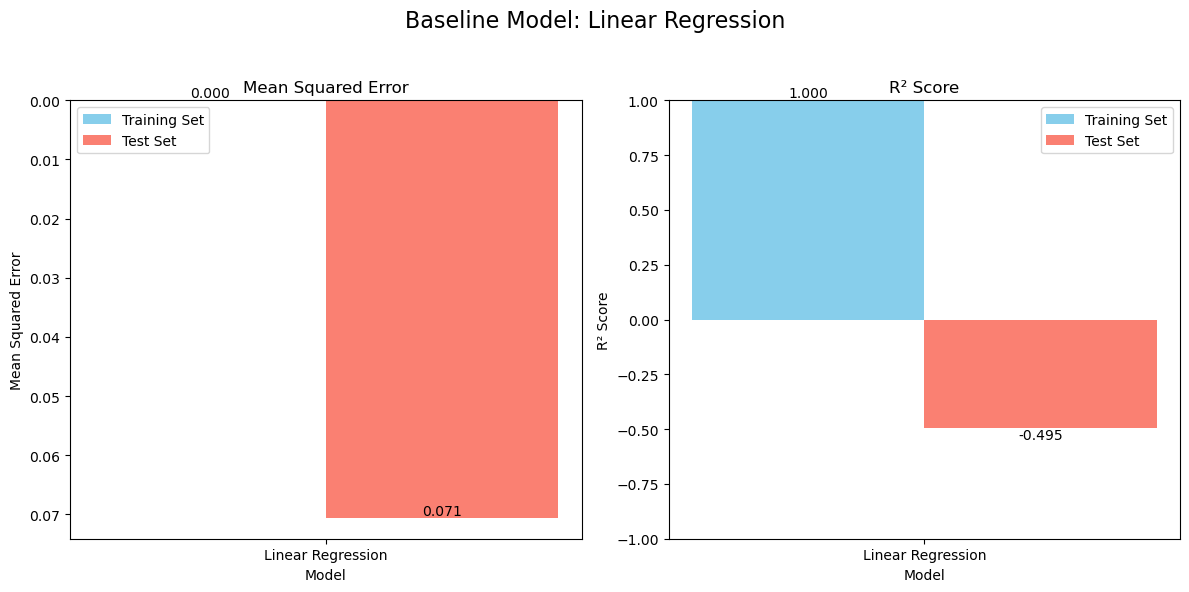

Baseline Linear Regression Evaluation:
Test MSE: 0.071
Test R²: -0.495


In [54]:
# Modified plotting function for a single regressor
def plot_baseline_metrics(X_train, y_train, X_test, y_test, model, model_name="Linear Regression"):
    """
    Plot MSE and R² scores for a single regression model on training and test sets.
    
    Parameters:
    - X_train, y_train: Training data
    - X_test, y_test: Test data
    - model: Trained regression model
    - model_name: Name of the model for display
    
    Returns:
    - mse_scores, r2_scores: Dictionaries with training and test scores
    """
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Baseline Model: {model_name}", size=16)
    
    # Calculate MSE
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_mse = sklearn.metrics.mean_squared_error(y_train, train_preds)
    test_mse = sklearn.metrics.mean_squared_error(y_test, test_preds)
    
    # Calculate R²
    train_r2 = sklearn.metrics.r2_score(y_train, train_preds)
    test_r2 = sklearn.metrics.r2_score(y_test, test_preds)
    
    # Plot MSE
    ax1 = plt.subplot(121)
    ind = np.array([0])  # Single model
    width = 0.35
    p1 = ax1.bar(ind - width/2, [train_mse], width, label='Training Set', color='skyblue')
    p2 = ax1.bar(ind + width/2, [test_mse], width, label='Test Set', color='salmon')
    ax1.text(ind - width/2, train_mse, f'{train_mse:.3f}', ha='center', va='bottom')
    ax1.text(ind + width/2, test_mse, f'{test_mse:.3f}', ha='center', va='bottom')
    ax1.set_xticks(ind)
    ax1.set_xticklabels([model_name])
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Mean Squared Error')
    ax1.set_title('Mean Squared Error')
    ax1.legend()
    ax1.invert_yaxis()  # Lower MSE is better
    
    # Plot R²
    ax2 = plt.subplot(122)
    p1 = ax2.bar(ind - width/2, [train_r2], width, label='Training Set', color='skyblue')
    p2 = ax2.bar(ind + width/2, [test_r2], width, label='Test Set', color='salmon')
    ax2.text(ind - width/2, train_r2, f'{train_r2:.3f}', ha='center', va='bottom' if train_r2 >= 0 else 'top')
    ax2.text(ind + width/2, test_r2, f'{test_r2:.3f}', ha='center', va='bottom' if test_r2 >= 0 else 'top')
    ax2.set_xticks(ind)
    ax2.set_xticklabels([model_name])
    ax2.set_xlabel('Model')
    ax2.set_ylabel('R² Score')
    ax2.set_title('R² Score')
    ax2.set_ylim(-1, 1)  # R² can be negative
    ax2.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    mse_scores = {model_name: {'train': train_mse, 'test': test_mse}}
    r2_scores = {model_name: {'train': train_r2, 'test': test_r2}}
    return mse_scores, r2_scores

# Plot and evaluate the baseline model
mse_scores, r2_scores = plot_baseline_metrics(X_train, y_train, X_test, y_test, baseline_model)

# Print test set evaluation
print("Baseline Linear Regression Evaluation:")
print(f"Test MSE: {mse_scores['Linear Regression']['test']:.3f}")
print(f"Test R²: {r2_scores['Linear Regression']['test']:.3f}")

NameError: name 'y_pred_sk' is not defined

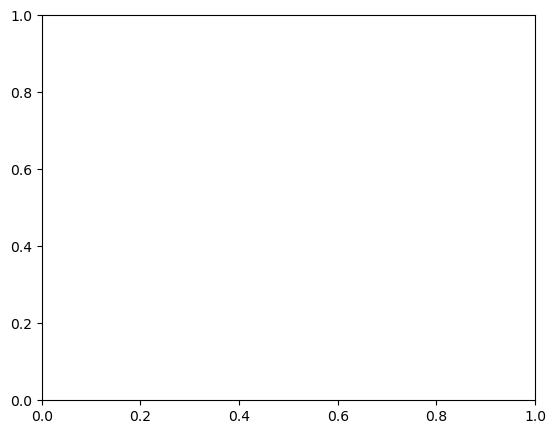

In [55]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');


# Plot Competitors

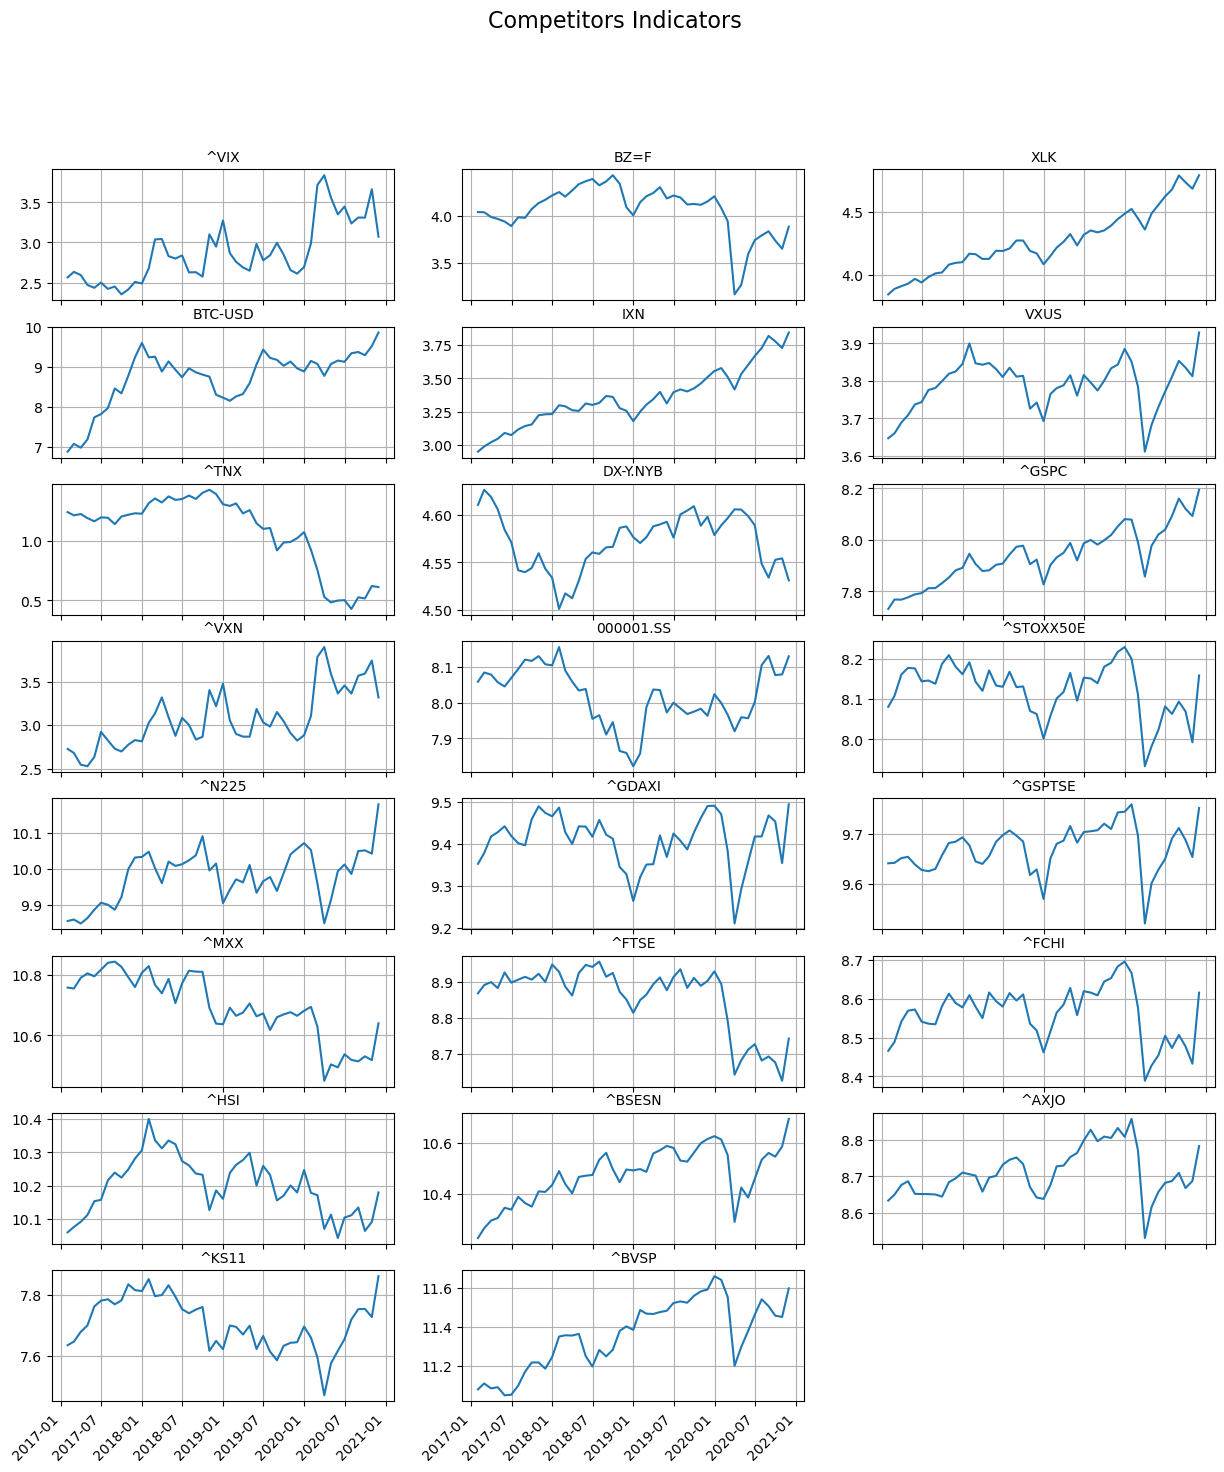

In [153]:
plot_group_indicators(transformed_df, competitors_indicators, "Competitors")

# Plot Technical Indicator

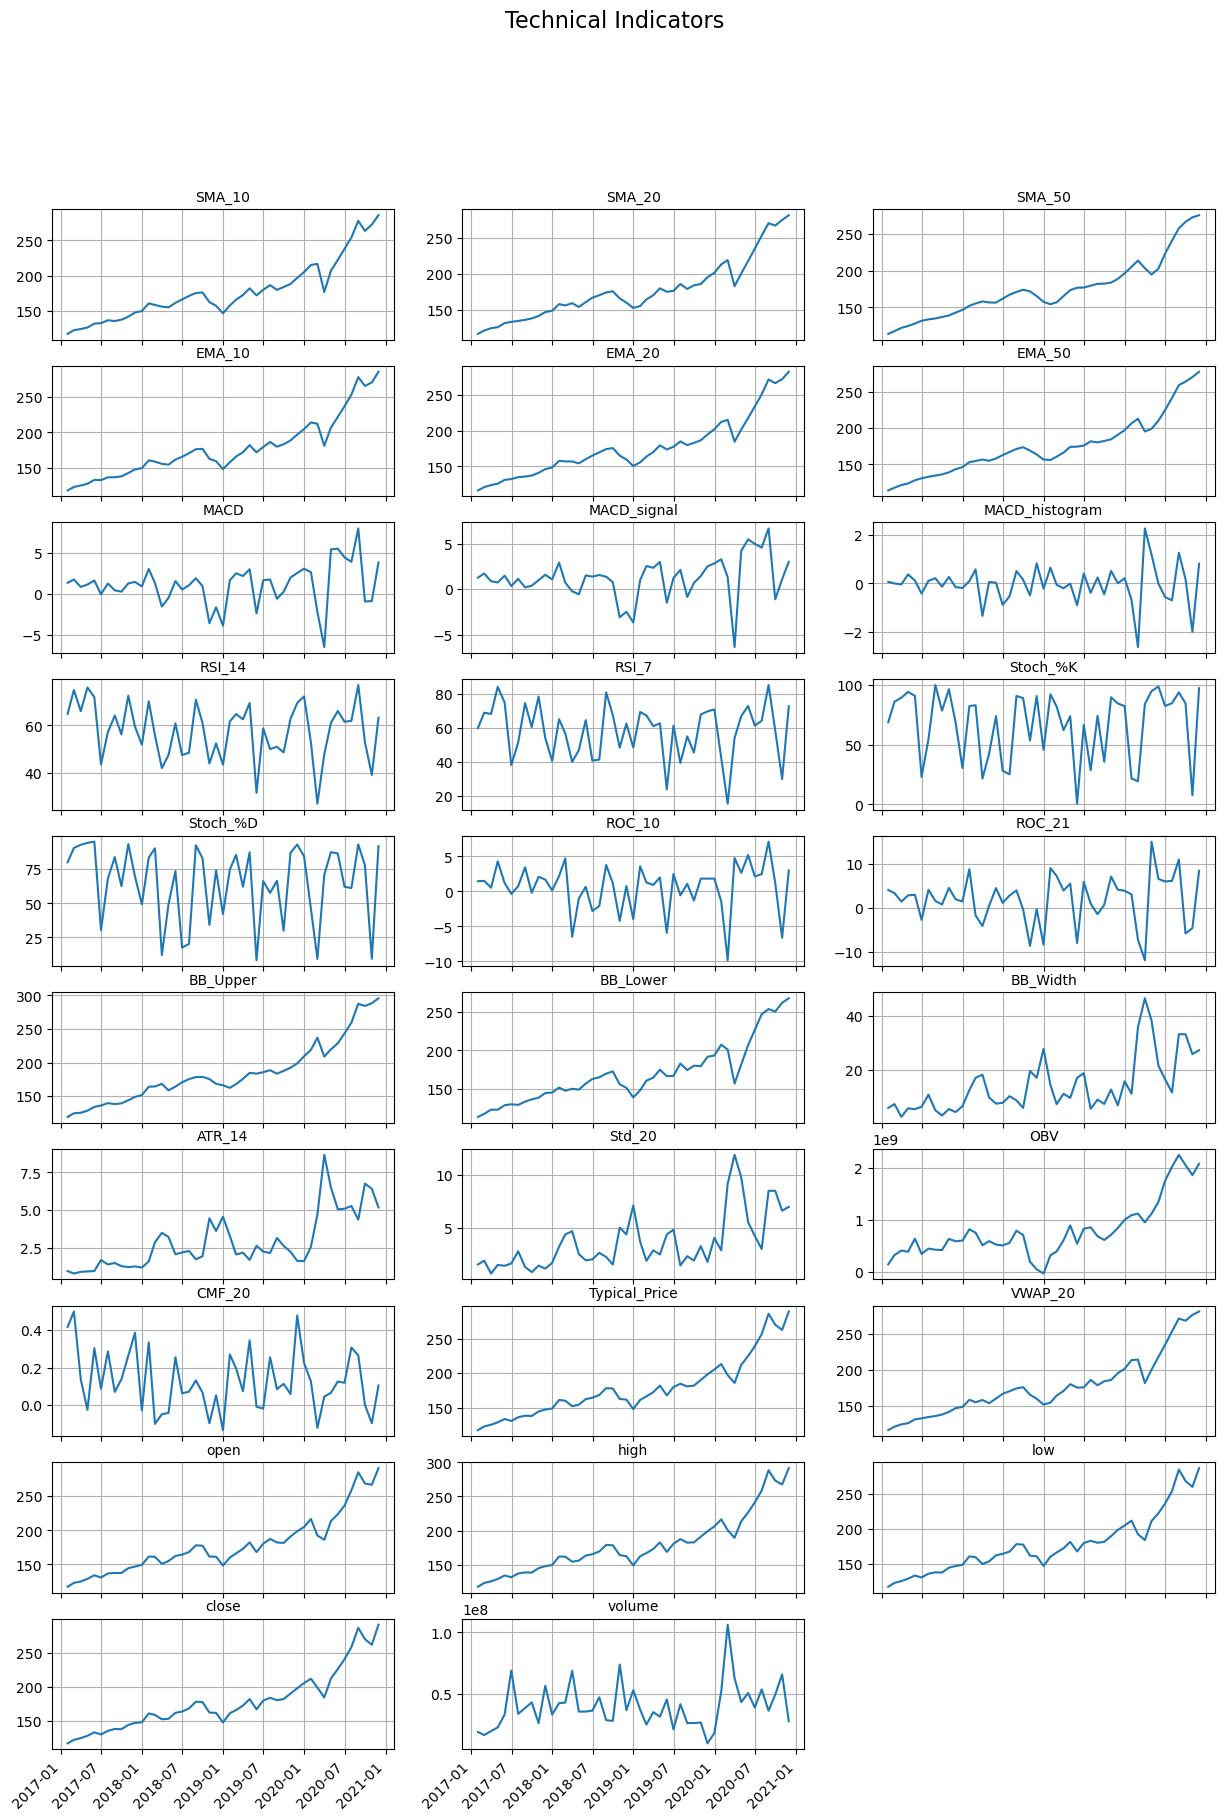

In [146]:
plot_group_indicators(outliner_df, technical_indicators, "Technical")

# Plot Macro Indicators

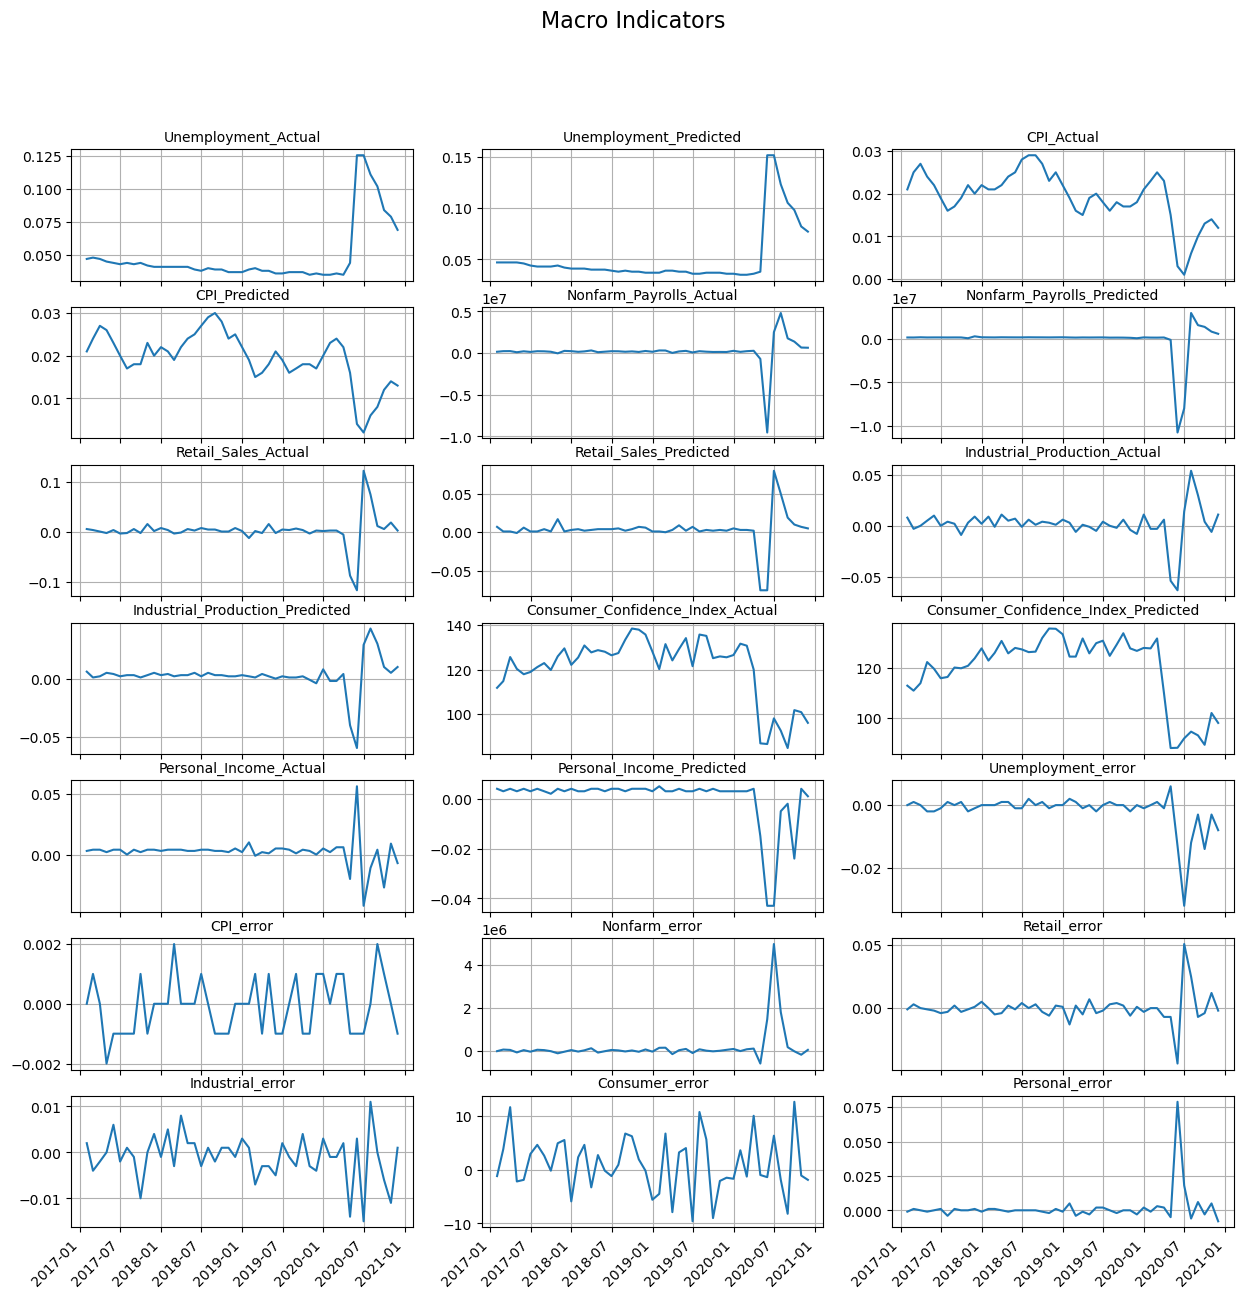

In [147]:
plot_group_indicators(outliner_df, macro_indicators, "Macro")

# Plot News

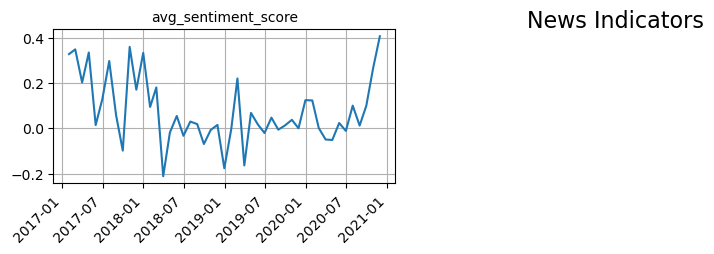

In [148]:
plot_group_indicators(outliner_df, news_indicators, "News")

# Train Test Split

In [9]:
mask = np.random.rand(len(data)) < 0.8
train_data = data[mask]
test_data = data[~mask]
print('Training dataset length: '+str(len(train_data)))
print('Testing dataset length: '+str(len(test_data)))

Training dataset length: 39
Testing dataset length: 9


In [10]:
# Define the dependent and independent variables
y_train = train_data['Future_Log_Returns']
X_train = train_data.select_dtypes(include=['int64', 'float64'])

y_test = test_data['Future_Log_Returns']
X_test = test_data.select_dtypes(include=['int64', 'float64'])

# Add a constant term to the independent variables (for intercept in the regression)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [11]:
X_test

const        open        high         low       close    volume  \
date                                                                          
2017-04-30    1.0  128.900559  128.947851  128.408763  128.616837  22771900   
2017-06-30    1.0  130.854451  131.508821  130.105255  130.532013  68898300   
2017-07-31    1.0  136.800673  136.971370  135.539355  135.833344  33848600   
2017-12-31    1.0  149.406355  149.434927  148.292024  148.349167  33186000   
2018-04-30    1.0  154.990970  155.954472  153.149807  153.531403  35615300   
2018-09-30    1.0  177.476711  178.405709  177.151087  177.936417  28076800   
2018-11-30    1.0  161.262414  162.306335  160.457910  162.210556  36722800   
2019-04-30    1.0  182.320840  182.676870  181.098835  182.378571  31495300   
2020-12-31    1.0  304.703342  306.037577  303.622330  305.550629  21611400   

            Unemployment_Actual  Unemployment_Predicted  CPI_Actual  \
date                                                                  
2017-04-30                0.045                   0.047       0.024   
2017-06-30                0.043                   0.044       0.019   
2017-07-31                0.044                   0.043       0.016   
2017-12-31                0.041                   0.041       0.022   
2018-04-30                0.041                   0.040       0.024   
2018-09-30                0.039                   0.038       0.027   
2018-11-30                0.037                   0.037       0.025   
2019-04-30                0.038                   0.038       0.019   
2020-12-31                0.067                   0.068       0.012   

            CPI_Predicted  ...   ^KS11_lag1  ^KS11_lag10  ^KS11_lag42  \
date                       ...                                          
2017-04-30          0.026  ...  2209.459961  2148.610107  2091.639893   
2017-06-30          0.020  ...  2395.659912  2361.830078  2219.669922   
2017-07-31          0.017  ...  2400.989990  2425.100098  2347.379883   
2017-12-31          0.022  ...  2467.489990  2469.479980  2501.929932   
2018-04-30          0.024  ...  2492.399902  2457.489990  2427.360107   
2018-09-30          0.028  ...  2355.429932  2318.250000  2295.260010   
2018-11-30          0.025  ...  2114.100098  2088.060059  2309.570068   
2019-04-30          0.018  ...  2216.429932  2242.879883  2195.439941   
2020-12-31          0.011  ...  2873.469971  2771.790039  2267.149902   

            ^KS11_lag63  ^BVSP_lag1  ^BVSP_lag10  ^BVSP_lag42  ^BVSP_lag63  \
date                                                                         
2017-04-30  2083.590088     64677.0      62826.0      66662.0      66034.0   
2017-06-30  2160.229980     62239.0      61626.0      66722.0      64984.0   
2017-07-31  2205.439941     65497.0      65212.0      62711.0      65403.0   
2017-12-31  2394.469971     76402.0      72429.0      74800.0      74294.0   
2018-04-30  2598.189941     86445.0      82862.0      85481.0      84698.0   
2018-09-30  2326.129883     80000.0      75429.0      79220.0      72763.0   
2018-11-30  2322.879883     89710.0      85973.0      81612.0      76678.0   
2019-04-30  2183.360107     96188.0      93083.0      95584.0      95639.0   
2020-12-31  2327.889893    119306.0     117947.0      93952.0      95479.0   

            avg_sentiment_score  Future_Log_Returns  
date                                                 
2017-04-30             0.334042            0.038233  
2017-06-30             0.128795            0.039810  
2017-07-31             0.296430            0.020524  
2017-12-31             0.332320            0.083947  
2018-04-30            -0.018729            0.055179  
2018-09-30            -0.069411           -0.089877  
2018-11-30             0.014762           -0.090589  
2019-04-30             0.067757           -0.085832  
2020-12-31             0.317414                 NaN  

[9 rows x 188 columns]

In [14]:
## Checking
# for i in X_test.columns:
#     print(i)

# Fit Regression Model 

DNN model shape validation passed. Output shape: torch.Size([1, 1])
LSTM model shape validation passed. Output shape: torch.Size([1, 1])
CNN model shape validation passed. Output shape: torch.Size([1, 1])
LR:
  MSE: 0.166 (±0.155)
  RMSE: 0.370 (±0.169)
  MAE: 0.275 (±0.080)
  R2: -2.476 (±1.939)

KNN:
  MSE: 0.082 (±0.033)
  RMSE: 0.281 (±0.057)
  MAE: 0.230 (±0.066)
  R2: -1.082 (±0.977)

CART:
  MSE: 0.126 (±0.074)
  RMSE: 0.332 (±0.125)
  MAE: 0.282 (±0.118)
  R2: -1.410 (±0.784)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. Thi

RF:
  MSE: 0.079 (±0.037)
  RMSE: 0.272 (±0.071)
  MAE: 0.226 (±0.065)
  R2: -0.780 (±0.439)

GB:
  MSE: 0.081 (±0.053)
  RMSE: 0.266 (±0.098)
  MAE: 0.220 (±0.091)
  R2: -0.695 (±0.761)

SVR:
  MSE: 0.067 (±0.024)
  RMSE: 0.255 (±0.048)
  MAE: 0.209 (±0.048)
  R2: -0.804 (±1.009)

DNN:
  MSE: 0.117 (±0.066)
  RMSE: 0.327 (±0.099)
  MAE: 0.259 (±0.068)
  R2: -1.820 (±1.487)

LSTM:
  MSE: 0.154 (±0.100)
  RMSE: 0.371 (±0.126)
  MAE: 0.294 (±0.097)
  R2: -3.153 (±3.264)

CNN:
  MSE: 0.257 (±0.084)
  RMSE: 0.501 (±0.083)
  MAE: 0.455 (±0.069)
  R2: -6.116 (±4.188)

Best Model (SVR) Test Performance:
  MSE: 0.0424
  RMSE: 0.2059
  MAE: 0.1635
  R2: 0.1019


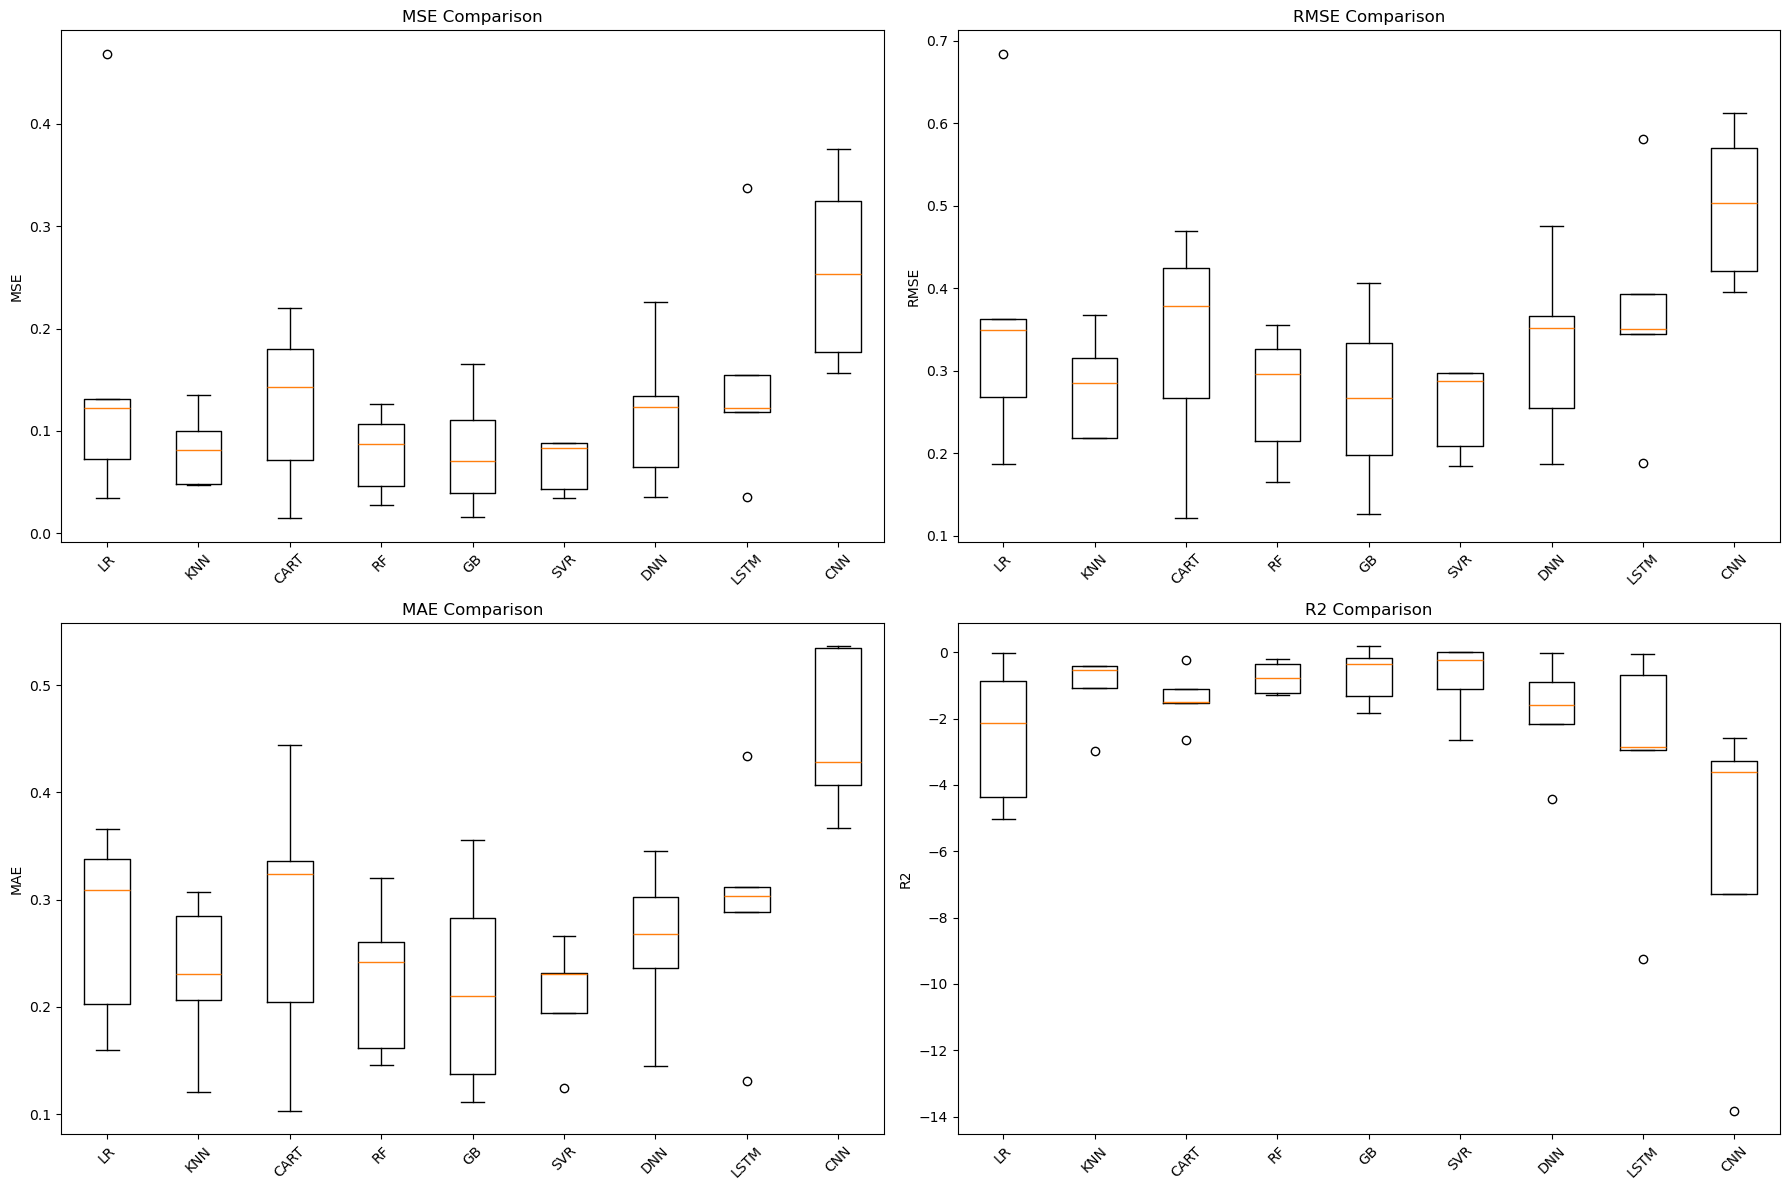

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data (assuming train_data and test_data are already loaded)
y_train = train_data['Future_Log_Returns']
X_train = train_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')
y_test = test_data['Future_Log_Returns']
X_test = test_data.select_dtypes(include=['int64', 'float64']).drop(columns=['Future_Log_Returns'], errors='ignore')

# Preprocessing: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_features = X_train.shape[1]

# --- PyTorch Model Definitions ---
class DNN(nn.Module):
    def __init__(self, n_features):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(n_features, 50, batch_first=True)
        self.fc = nn.Linear(50, 1)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

class CNN(nn.Module):
    def __init__(self, n_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * n_features, 50)
        self.fc2 = nn.Linear(50, 1)
    
    def forward(self, x):
        # Expect x to be [batch_size, 1, n_features]
        x = torch.relu(self.conv1(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# --- Validation Check for Model Shapes ---
def _validate_model_shapes(model, model_name, n_features):
    with torch.no_grad():
        if model_name in ['CNN', 'LSTM']:
            test_input = torch.randn(1, 1, n_features)  # Shape: [1, 1, n_features]
        else:
            test_input = torch.randn(1, n_features)     # Shape: [1, n_features]
        try:
            output = model(test_input)
            print(f"{model_name} model shape validation passed. Output shape: {output.shape}")
        except Exception as e:
            print(f"Shape validation failed for {model_name}: {str(e)}")

# --- Training Function for PyTorch Models ---
def train_pytorch_model(model, model_name, X_train, y_train, X_val, y_val, epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    
    # Reshape for LSTM and CNN
    if model_name in ['LSTM', 'CNN']:
        X_train_tensor = X_train_tensor.unsqueeze(1)  # [batch_size, 1, n_features]
        X_val_tensor = X_val_tensor.unsqueeze(1)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        return val_outputs.numpy().flatten()

# --- Configuration ---
num_folds = 5
seed = 7
scaled_models = ['KNN', 'SVR', 'DNN', 'LSTM', 'CNN']
epochs = 50
batch_size = 32

# --- Define Models ---
models = [
    ('LR', LinearRegression(), 'sklearn'),
    ('KNN', KNeighborsRegressor(), 'sklearn'),
    ('CART', DecisionTreeRegressor(random_state=seed), 'sklearn'),
    ('RF', RandomForestRegressor(n_jobs=-1, random_state=seed), 'sklearn'),
    ('GB', GradientBoostingRegressor(random_state=seed), 'sklearn'),
    ('SVR', SVR(), 'sklearn'),
    ('DNN', lambda: DNN(n_features), 'pytorch'),
    ('LSTM', lambda: LSTMModel(n_features), 'pytorch'),
    ('CNN', lambda: CNN(n_features), 'pytorch')
]

# Validate model shapes for PyTorch models
for name, model_func, model_type in models:
    if model_type == 'pytorch':
        _validate_model_shapes(model_func(), name, n_features)

# --- Cross-Validation and Training ---
results = {'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for name, model, model_type in models:
    if model_type == 'sklearn':
        X_train_current = X_train_scaled if name in scaled_models else X_train
        cv_results = cross_validate(model, X_train_current, y_train, cv=kfold,
                                    scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                                             'neg_mean_absolute_error', 'r2'])
        fold_mse = -cv_results['test_neg_mean_squared_error']
        fold_rmse = -cv_results['test_neg_root_mean_squared_error']
        fold_mae = -cv_results['test_neg_mean_absolute_error']
        fold_r2 = cv_results['test_r2']
    elif model_type == 'pytorch':
        fold_mse, fold_rmse, fold_mae, fold_r2 = [], [], [], []
        for train_idx, val_idx in kfold.split(X_train_scaled):
            X_train_fold = X_train_scaled[train_idx]
            y_train_fold = y_train.values[train_idx]
            X_val_fold = X_train_scaled[val_idx]
            y_val_fold = y_train.values[val_idx]
            model_instance = model()  # Create new instance for each fold
            val_pred = train_pytorch_model(model_instance, name, X_train_fold, y_train_fold,
                                           X_val_fold, y_val_fold, epochs, batch_size)
            mse = mean_squared_error(y_val_fold, val_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_val_fold, val_pred)
            r2 = r2_score(y_val_fold, val_pred)
            fold_mse.append(mse)
            fold_rmse.append(rmse)
            fold_mae.append(mae)
            fold_r2.append(r2)
    
    # Store results
    results['MSE'].append(fold_mse)
    results['RMSE'].append(fold_rmse)
    results['MAE'].append(fold_mae)
    results['R2'].append(fold_r2)
    
    # Print results
    print(f"{name}:")
    print(f"  MSE: {np.mean(fold_mse):.3f} (±{np.std(fold_mse):.3f})")
    print(f"  RMSE: {np.mean(fold_rmse):.3f} (±{np.std(fold_rmse):.3f})")
    print(f"  MAE: {np.mean(fold_mae):.3f} (±{np.std(fold_mae):.3f})")
    print(f"  R2: {np.mean(fold_r2):.3f} (±{np.std(fold_r2):.3f})\n")

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
model_names = [name for name, _, _ in models]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.boxplot(results[metric])
    ax.set_title(f'{metric} Comparison')
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel(metric)

plt.tight_layout()
plt.savefig('model_comparison.png')

# --- Test Best Model ---
best_idx = np.argmin([np.mean(scores) for scores in results['MSE']])
best_model_name, best_model, best_model_type = models[best_idx]

if best_model_type == 'sklearn':
    X_train_final = X_train_scaled if best_model_name in scaled_models else X_train
    X_test_final = X_test_scaled if best_model_name in scaled_models else X_test
    best_model.fit(X_train_final, y_train)
    y_pred = best_model.predict(X_test_final)
elif best_model_type == 'pytorch':
    model_instance = best_model()
    train_pytorch_model(model_instance, best_model_name, X_train_scaled, y_train.values, 
                        X_train_scaled, y_train.values, epochs, batch_size)  # Using train as val for simplicity
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    if best_model_name in ['LSTM', 'CNN']:
        X_test_tensor = X_test_tensor.unsqueeze(1)
    model_instance.eval()
    with torch.no_grad():
        y_pred = model_instance(X_test_tensor).numpy().flatten()

# --- Test Set Performance ---
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Best Model ({best_model_name}) Test Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R2: {test_r2:.4f}")

Training dataset length: 39
Testing dataset length: 8
LR:
  MSE: 0.046 (±0.025)
  RMSE: 0.208 (±0.055)
  MAE: 0.153 (±0.021)
  R2: 0.134 (±0.367)

KNN:
  MSE: 0.056 (±0.011)
  RMSE: 0.236 (±0.024)
  MAE: 0.191 (±0.030)
  R2: -0.077 (±0.237)

CART:
  MSE: 0.074 (±0.035)
  RMSE: 0.266 (±0.059)
  MAE: 0.228 (±0.055)
  R2: -0.385 (±0.496)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.6.1. Thi

RF:
  MSE: 0.050 (±0.019)
  RMSE: 0.221 (±0.042)
  MAE: 0.167 (±0.048)
  R2: 0.066 (±0.250)

GB:
  MSE: 0.061 (±0.017)
  RMSE: 0.244 (±0.034)
  MAE: 0.195 (±0.036)
  R2: -0.136 (±0.225)

SVR:
  MSE: 0.051 (±0.012)
  RMSE: 0.224 (±0.029)
  MAE: 0.178 (±0.041)
  R2: 0.032 (±0.232)

DNN:
  MSE: 0.061 (±0.019)
  RMSE: 0.244 (±0.039)
  MAE: 0.201 (±0.039)
  R2: -0.154 (±0.279)

LSTM:
  MSE: 0.054 (±0.019)
  RMSE: 0.228 (±0.041)
  MAE: 0.182 (±0.041)
  R2: -0.008 (±0.273)

CNN:
  MSE: 0.251 (±0.091)
  RMSE: 0.492 (±0.097)
  MAE: 0.449 (±0.093)
  R2: -3.761 (±1.864)



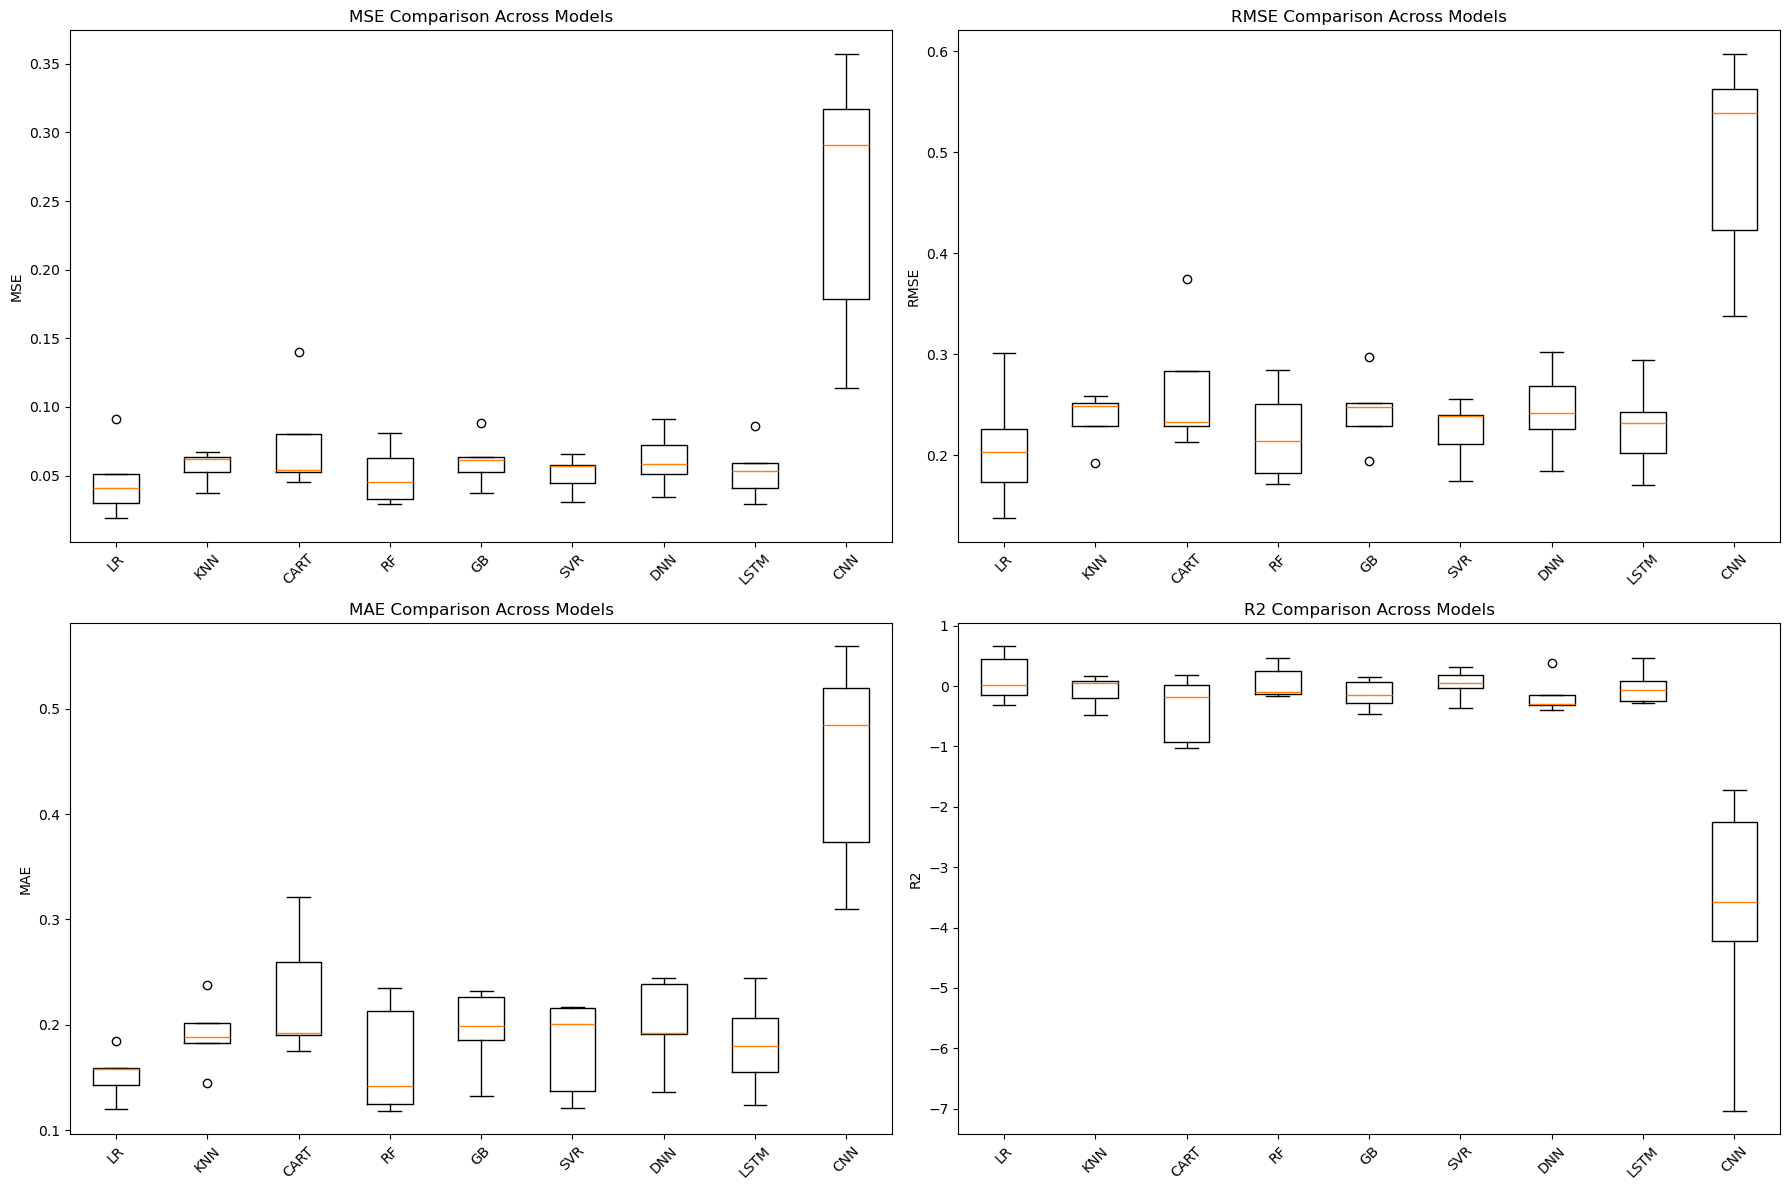

Best Model (LR) Test Performance:
  MSE: 0.1712
  RMSE: 0.4137
  MAE: 0.3554
  R2: -4.5573


In [130]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
rng = np.random.RandomState(42)

# Assuming 'outlier_df' is the original DataFrame; replace with your actual data
# Here, 'scaled_df' is assumed to be the input DataFrame as per the original code
# Split data into training and testing sets
mask = rng.rand(len(scaled_df)) < 0.8
train_data = scaled_df[mask]
test_data = scaled_df[~mask]

print(f"Training dataset length: {len(train_data)}")
print(f"Testing dataset length: {len(test_data)}")

# Define target and features
y_train = train_data["Future_Log_Returns"]
X_train = train_data.select_dtypes(include=["int64", "float64"]).drop(
    columns=["Future_Log_Returns"], errors="ignore"
)

y_test = test_data["Future_Log_Returns"]
X_test = test_data.select_dtypes(include=["int64", "float64"]).drop(
    columns=["Future_Log_Returns"], errors="ignore"
)

# Scale features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_features = X_train.shape[1]

# --- PyTorch Model Definitions ---

class DNN(nn.Module):
    def __init__(self, n_features):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(n_features, 50, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

class CNN(nn.Module):
    def __init__(self, n_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * n_features, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: (batch, 1, features)
        x = torch.relu(self.conv1(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- Training Functions for PyTorch Models ---

def train_pytorch_model_cv(model, model_name, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """Train PyTorch model for cross-validation and return validation predictions."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Adjust input shape for LSTM and CNN
    if model_name == "LSTM":
        X_train_tensor = X_train_tensor.unsqueeze(1)  # (batch, 1, features)
        X_val_tensor = X_val_tensor.unsqueeze(1)
    elif model_name == "CNN":
        X_train_tensor = X_train_tensor  # Already adjusted in forward
        X_val_tensor = X_val_tensor

    # Training loop
    model.train()
    for _ in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i : i + batch_size]
            batch_y = y_train_tensor[i : i + batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Validation predictions
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_pred = val_outputs.numpy().flatten()
    return val_pred

def train_pytorch_model_full(model, model_name, X_train, y_train, epochs=50, batch_size=32):
    """Train PyTorch model on full training set."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    if model_name == "LSTM":
        X_train_tensor = X_train_tensor.unsqueeze(1)
    # CNN shape is handled in the forward method

    model.train()
    for _ in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i : i + batch_size]
            batch_y = y_train_tensor[i : i + batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

# --- Metrics Computation ---

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# --- Configuration ---

num_folds = 5
seed = 7
scaled_models = ["KNN", "SVR", "DNN", "LSTM", "CNN"]
epochs = 50
batch_size = 32

# --- Define Models ---

models = [
    ("LR", LinearRegression(), "sklearn"),
    ("KNN", KNeighborsRegressor(), "sklearn"),
    ("CART", DecisionTreeRegressor(random_state=seed), "sklearn"),
    ("RF", RandomForestRegressor(n_jobs=-1, random_state=seed), "sklearn"),
    ("GB", GradientBoostingRegressor(random_state=seed), "sklearn"),
    ("SVR", SVR(), "sklearn"),
    ("DNN", lambda: DNN(n_features), "pytorch"),
    ("LSTM", lambda: LSTMModel(n_features), "pytorch"),
    ("CNN", lambda: CNN(n_features), "pytorch"),
]

# --- Cross-Validation and Results Storage ---

results = {"MSE": [], "RMSE": [], "MAE": [], "R2": []}
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for name, model, model_type in models:
    fold_mse, fold_rmse, fold_mae, fold_r2 = [], [], [], []

    if model_type == "sklearn":
        X_train_current = X_train_scaled if name in scaled_models else X_train
        cv_results = cross_validate(
            model,
            X_train_current,
            y_train,
            cv=kfold,
            scoring=[
                "neg_mean_squared_error",
                "neg_root_mean_squared_error",
                "neg_mean_absolute_error",
                "r2",
            ],
        )
        fold_mse = -cv_results["test_neg_mean_squared_error"]
        fold_rmse = -cv_results["test_neg_root_mean_squared_error"]
        fold_mae = -cv_results["test_neg_mean_absolute_error"]
        fold_r2 = cv_results["test_r2"]

    elif model_type == "pytorch":
        for train_idx, val_idx in kfold.split(X_train_scaled):
            X_train_fold = X_train_scaled[train_idx]
            y_train_fold = y_train.values[train_idx]
            X_val_fold = X_train_scaled[val_idx]
            y_val_fold = y_train.values[val_idx]
            model_instance = model()  # New instance per fold
            val_pred = train_pytorch_model_cv(
                model_instance, name, X_train_fold, y_train_fold, X_val_fold, y_val_fold, epochs, batch_size
            )
            mse, rmse, mae, r2 = compute_metrics(y_val_fold, val_pred)
            fold_mse.append(mse)
            fold_rmse.append(rmse)
            fold_mae.append(mae)
            fold_r2.append(r2)

    # Store results
    results["MSE"].append(fold_mse)
    results["RMSE"].append(fold_rmse)
    results["MAE"].append(fold_mae)
    results["R2"].append(fold_r2)

    # Print performance
    print(f"{name}:")
    print(f"  MSE: {np.mean(fold_mse):.3f} (±{np.std(fold_mse):.3f})")
    print(f"  RMSE: {np.mean(fold_rmse):.3f} (±{np.std(fold_rmse):.3f})")
    print(f"  MAE: {np.mean(fold_mae):.3f} (±{np.std(fold_mae):.3f})")
    print(f"  R2: {np.mean(fold_r2):.3f} (±{np.std(fold_r2):.3f})\n")

# --- Visualize Results ---

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
metrics = ["MSE", "RMSE", "MAE", "R2"]
model_names = [name for name, _, _ in models]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.boxplot(results[metric])
    ax.set_title(f"{metric} Comparison Across Models")
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

# --- Test Best Model ---

best_idx = np.argmin([np.mean(scores) for scores in results["MSE"]])
best_model_name, best_model, best_model_type = models[best_idx]

if best_model_type == "sklearn":
    X_train_final = X_train_scaled if best_model_name in scaled_models else X_train
    X_test_final = X_test_scaled if best_model_name in scaled_models else X_test
    best_model.fit(X_train_final, y_train)
    y_pred = best_model.predict(X_test_final)
else:  # PyTorch
    model_instance = best_model()
    train_pytorch_model_full(model_instance, best_model_name, X_train_scaled, y_train.values, epochs, batch_size)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    if best_model_name == "LSTM":
        X_test_tensor = X_test_tensor.unsqueeze(1)
    # CNN shape is handled in forward
    model_instance.eval()
    with torch.no_grad():
        y_pred = model_instance(X_test_tensor).numpy().flatten()

# --- Test Set Performance ---

test_mse, test_rmse, test_mae, test_r2 = compute_metrics(y_test, y_pred)

print(f"Best Model ({best_model_name}) Test Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R2: {test_r2:.4f}")

In [135]:
n_features

188

In [133]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Assuming scaled_df is a preprocessed DataFrame with features and 'Future_Log_Returns'

# Step 1: Data Preparation
seq_len = 5
n_features = scaled_df.shape[1] - 1  # excluding 'Future_Log_Returns'

# Create sequences
X_seq = []
y_seq = []
for i in range(seq_len, len(scaled_df)):
    X_seq.append(scaled_df.iloc[i-seq_len:i].drop(columns=['Future_Log_Returns']).values)
    y_seq.append(scaled_df.iloc[i]['Future_Log_Returns'])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split into training and testing sets (time-based)
train_size = int(0.8 * len(X_seq))
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

# Step 2: Model Definitions
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VanillaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)  # concatenate forward and backward
        x = self.fc(h_n)
        return x

class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len) for Conv1d
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # (batch, seq_len, 64) for LSTM
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

# Training function for PyTorch models
def train_pytorch_model(model, X_train, y_train, epochs=50, batch_size=16):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

# Prediction function for PyTorch models
def predict_pytorch_model(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        outputs = model(X_tensor)
        return outputs.numpy().flatten()

# Step 3: Define models
models = [
    ('Baseline', LinearRegression(), 'sklearn'),
    ('Vanilla LSTM', lambda: VanillaLSTM(input_size=n_features, hidden_size=50, num_layers=1, output_size=1), 'pytorch'),
    ('Stacked LSTM', lambda: VanillaLSTM(input_size=n_features, hidden_size=50, num_layers=2, output_size=1), 'pytorch'),
    ('Bidirectional LSTM', lambda: BidirectionalLSTM(input_size=n_features, hidden_size=50, num_layers=1, output_size=1), 'pytorch'),
    ('CNN-LSTM', lambda: CNNLSTM(input_size=n_features, hidden_size=50, num_layers=1, output_size=1), 'pytorch')
]

# Step 4: Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
results = {'Model': [], 'Fold': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for name, model, model_type in models:
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]
        
        if model_type == 'sklearn':
            X_train_lr_fold = X_train_fold[:, -1, :]  # last time step
            X_val_lr_fold = X_val_fold[:, -1, :]
            model.fit(X_train_lr_fold, y_train_fold)
            y_pred = model.predict(X_val_lr_fold)
        else:
            model_instance = model()
            train_pytorch_model(model_instance, X_train_fold, y_train_fold)
            y_pred = predict_pytorch_model(model_instance, X_val_fold)
        
        # Compute metrics
        mse = mean_squared_error(y_val_fold, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        
        # Store results
        results['Model'].append(name)
        results['Fold'].append(fold)
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
        results['MAE'].append(mae)
        results['R2'].append(r2)

# Summarize CV results
results_df = pd.DataFrame(results)
summary = results_df.groupby('Model').agg({'MSE': ['mean', 'std'], 'RMSE': ['mean', 'std'], 'MAE': ['mean', 'std'], 'R2': ['mean', 'std']})
print("Cross-Validation Summary:")
print(summary)

# Step 5: Select best model based on R²
best_model_name = summary['R2']['mean'].idxmax()
print(f"\nBest model based on R²: {best_model_name}")

# Step 6: Train best model on full training set and evaluate on test set
best_model_type = [m[2] for m in models if m[0] == best_model_name][0]
best_model = [m[1] for m in models if m[0] == best_model_name][0]

if best_model_type == 'sklearn':
    X_train_lr_full = X_train[:, -1, :]
    X_test_lr_full = X_test[:, -1, :]
    best_model.fit(X_train_lr_full, y_train)
    y_pred = best_model.predict(X_test_lr_full)
else:
    model_instance = best_model()
    train_pytorch_model(model_instance, X_train, y_train)
    y_pred = predict_pytorch_model(model_instance, X_test)

# Compute test metrics
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"\nTest performance of {best_model_name}:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R2: {test_r2:.4f}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/02/hv2vnm3n0d35b_wnxjv6zgj00000gn/T/ipykernel_2242/3361323543.py", line 120, in <module>
    model.fit(X_train_lr_fold, y_train_fold)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_base.py", line 578, in fit
    Parameters
           ^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    Notes
          
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 997, in check_array
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 521,

In [194]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- Data Preparation ---
def prepare_data(df, seq_len=10, test_size=0.2):
    """Prepare time series data with sequences."""
    # Convert Period columns to numerical values
    for col in df.columns:
        if pd.api.types.is_period_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)
    
    # Select numerical columns excluding target
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('Future_Log_Returns', errors='ignore')
    
    # Handle outliers with IQR
    for col in numerical_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        df[col] = df[col].clip(lower, upper)
    
    # Handle NaNs
    df[numerical_cols] = df[numerical_cols].fillna(method='ffill').fillna(0)
    
    # Create sequences
    X_seq, y_seq = [], []
    for i in range(seq_len, len(df)):
        X_seq.append(df.iloc[i-seq_len:i][numerical_cols].values)
        y_seq.append(df.iloc[i]['Future_Log_Returns'])
    X_seq, y_seq = np.array(X_seq, dtype=float), np.array(y_seq, dtype=float)
    
    # Validate data
    if not np.all(np.isfinite(X_seq)) or not np.all(np.isfinite(y_seq)):
        raise ValueError("Data contains NaN or infinite values")
    
    # Train-test split
    train_size = int((1 - test_size) * len(X_seq))
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]
    
    return X_train, y_train, X_test, y_test, numerical_cols

# --- Feature Selection ---
def select_features(X_train, y_train, numerical_cols, n_features=50):
    """Select top features using RFECV."""
    X_train_last = X_train[:, -1, :]
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    rfecv = RFECV(estimator, step=1, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
    rfecv.fit(X_train_last, y_train)
    
    selected_mask = rfecv.support_
    selected_features = numerical_cols[selected_mask]
    importances = rfecv.estimator_.feature_importances_
    feature_df = pd.DataFrame({'feature': selected_features, 'importance': importances}).sort_values('importance', ascending=False)
    top_features = feature_df.head(n_features)['feature'].tolist()
    selected_indices = [list(numerical_cols).index(f) for f in top_features]
    
    print(f"Selected {len(selected_indices)} features:")
    print(feature_df.head(n_features))
    
    return X_train[:, :, selected_indices], X_test[:, :, selected_indices], selected_indices

# --- Model Definitions ---
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        return self.fc(x)

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
        x = self.dropout(h_n)
        return self.fc(x)

class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        return self.fc(x)

# --- Training and Evaluation ---
def train_model(model, train_loader, X_test_tensor, y_test, epochs=50, patience=5, lr=0.0005):
    """Train a PyTorch model with early stopping."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_loss = float('inf')
    trigger = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
        # Validation on test set (can be expanded to proper CV)
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor).numpy().flatten()
            val_loss = mean_squared_error(y_test, y_pred)
            if val_loss < best_loss:
                best_loss = val_loss
                trigger = 0
            else:
                trigger += 1
                if trigger >= patience:
                    print("Early stopping triggered")
                    break
    return model

def evaluate_model(model, X_test_tensor, y_test, model_name):
    """Evaluate model and plot residuals."""
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Test Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals')
    plt.title(f"{model_name} Residuals")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Residual Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_residuals.png')
    plt.close()
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# --- Main Execution ---
if __name__ == "__main__":
    # Assuming scaled_df is available
    X_train, y_train, X_test, y_test, numerical_cols = prepare_data(scaled_df)
    X_train_sel, X_test_sel, sel_indices = select_features(X_train, y_train, numerical_cols)
    
    # Prepare tensors
    X_train_tensor = torch.tensor(X_train_sel, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_sel, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    
    # Define models to compare
    model_configs = [
        ('Vanilla LSTM', VanillaLSTM(len(sel_indices), 100, 2, 1)),
        ('Bidirectional LSTM', BidirectionalLSTM(len(sel_indices), 100, 2, 1)),
        ('CNN-LSTM', CNNLSTM(len(sel_indices), 100, 2, 1))
    ]
    
    # Train and evaluate each model
    results = {}
    for name, model in model_configs:
        print(f"\nTraining {name}...")
        trained_model = train_model(model, train_loader, X_test_tensor, y_test)
        results[name] = evaluate_model(trained_model, X_test_tensor, y_test, name)
    
    # Summary
    print("\nModel Comparison Summary:")
    for name, metrics in results.items():
        print(f"{name}: MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")

Selected 50 features:
                             feature  importance
72                        ^VXN_lag10    0.095380
76                   000001.SS_lag42    0.079458
36                     Nonfarm_error    0.061208
82                       ^N225_lag42    0.044207
4            Nonfarm_Payrolls_Actual    0.035530
48                        ^VIX_lag10    0.028841
90                        ^MXX_lag10    0.028659
46                      volume_lag42    0.023146
63                         VXUS_lag1    0.022174
80                        ^N225_lag1    0.022036
25                              MACD    0.021669
53                        BZ=F_lag42    0.019653
28                            RSI_14    0.018533
89                         ^MXX_lag1    0.018483
21                             ^FTSE    0.016503
52                        BZ=F_lag10    0.015021
98                       ^FCHI_lag63    0.014634
109                      ^BVSP_lag42    0.014062
11            Personal_Income_Actual    0.01369

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import itertools

# --- Data Preparation ---
def prepare_data(df, seq_len=10, test_size=0.2):
    """Prepare time series data with sequences."""
    # Convert Period columns to numerical values
    for col in df.columns:
        if pd.api.types.is_period_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)
    
    # Select numerical columns excluding target
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('Future_Log_Returns', errors='ignore')
    
    # Handle outliers with IQR
    for col in numerical_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        df[col] = df[col].clip(lower, upper)
    
    # Handle NaNs
    df[numerical_cols] = df[numerical_cols].fillna(method='ffill').fillna(0)
    
    # Create sequences
    X_seq, y_seq = [], []
    for i in range(seq_len, len(df)):
        X_seq.append(df.iloc[i-seq_len:i][numerical_cols].values)
        y_seq.append(df.iloc[i]['Future_Log_Returns'])
    X_seq, y_seq = np.array(X_seq, dtype=float), np.array(y_seq, dtype=float)
    
    # Validate data
    if not np.all(np.isfinite(X_seq)) or not np.all(np.isfinite(y_seq)):
        raise ValueError("Data contains NaN or infinite values")
    
    # Train-test split
    train_size = int((1 - test_size) * len(X_seq))
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]
    
    return X_train, y_train, X_test, y_test, numerical_cols

In [ ]:
# --- Feature Selection ---
def select_features(X_train, y_train, X_test, numerical_cols, n_features=50):
    """Select top features using RFECV."""
    X_train_last = X_train[:, -1, :]
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    rfecv = RFECV(estimator, step=1, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
    rfecv.fit(X_train_last, y_train)
    
    selected_mask = rfecv.support_
    selected_features = numerical_cols[selected_mask]
    importances = rfecv.estimator_.feature_importances_
    feature_df = pd.DataFrame({'feature': selected_features, 'importance': importances}).sort_values('importance', ascending=False)
    top_features = feature_df.head(n_features)['feature'].tolist()
    selected_indices = [list(numerical_cols).index(f) for f in top_features]
    
    print(f"Selected {len(selected_indices)} features:")
    print(feature_df.head(n_features))
    
    return X_train[:, :, selected_indices], X_test[:, :, selected_indices], selected_indices

# --- Model Definition ---
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
        x = self.dropout(h_n)
        return self.fc(x)

# --- Training and Evaluation ---
def train_model(model, train_loader, X_test_tensor, y_test, epochs=50, patience=5, lr=0.0005):
    """Train a PyTorch model with early stopping."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_loss = float('inf')
    trigger = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
        # Validation on test set
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor).numpy().flatten()
            val_loss = mean_squared_error(y_test, y_pred)
            if val_loss < best_loss:
                best_loss = val_loss
                trigger = 0
            else:
                trigger += 1
                if trigger >= patience:
                    print("Early stopping triggered")
                    break
    return model

def evaluate_model(model, X_test_tensor, y_test, model_name):
    """Evaluate model and plot residuals."""
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Test Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals')
    plt.title(f"{model_name} Residuals")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Residual Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_residuals.png')
    plt.close()
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# --- Hyperparameter Tuning ---
def tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test, sel_indices):
    """Tune the Bidirectional LSTM model using grid search."""
    # Define hyperparameter grid
    learning_rates = [0.001, 0.0005, 0.0001]
    hidden_sizes = [50, 100, 150]
    num_layers_list = [1, 2, 3]
    dropout_rates = [0.2, 0.3, 0.4]
    batch_sizes = [32, 64, 128]
    
    best_r2 = -float('inf')
    best_params = {}
    best_model = None
    
    # Generate all combinations
    param_combinations = list(itertools.product(learning_rates, hidden_sizes, num_layers_list, dropout_rates, batch_sizes))
    
    for lr, hidden_size, num_layers, dropout, batch_size in param_combinations:
        print(f"\nTesting combination: lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, batch_size={batch_size}")
        
        # Create DataLoader with current batch size
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        model = BidirectionalLSTM(input_size=len(sel_indices), hidden_size=hidden_size, num_layers=num_layers, output_size=1, dropout=dropout)
        
        # Train model
        trained_model = train_model(model, train_loader, X_test_tensor, y_test, epochs=50, patience=5, lr=lr)
        
        # Evaluate model
        metrics = evaluate_model(trained_model, X_test_tensor, y_test, f"Bidirectional LSTM (lr={lr}, hidden={hidden_size}, layers={num_layers}, dropout={dropout}, batch={batch_size})")
        
        # Check if this is the best model
        if metrics['R2'] > best_r2:
            best_r2 = metrics['R2']
            best_params = {'lr': lr, 'hidden_size': hidden_size, 'num_layers': num_layers, 'dropout': dropout, 'batch_size': batch_size}
            best_model = trained_model
    
    print("\nBest Hyperparameters:")
    print(best_params)
    print(f"Best R²: {best_r2:.4f}")
    
    return best_model, best_params

# --- Main Execution ---
if __name__ == "__main__":
    # Assuming scaled_df is available
    X_train, y_train, X_test, y_test, numerical_cols = prepare_data(scaled_df)
    X_train_sel, X_test_sel, sel_indices = select_features(X_train, y_train, X_test, numerical_cols)
    
    # Prepare tensors
    X_train_tensor = torch.tensor(X_train_sel, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_sel, dtype=torch.float32)
    
    # Tune Bidirectional LSTM
    best_model, best_params = tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test, sel_indices)
    
    # Final evaluation of the best model
    final_metrics = evaluate_model(best_model, X_test_tensor, y_test, "Best Bidirectional LSTM")
    print("\nFinal Model Performance:")
    for key, value in final_metrics.items():
        print(f"{key}: {value:.4f}")